In [24]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import math
from torch_geometric.data import Data
import numpy as np



def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):# H
        color = 'lightgrey'
    elif(atomic_num ==6): # C
        color = 'black'
    elif(atomic_num ==8): # O
        color = 'red'
    elif(atomic_num ==7): # N
        color = 'blue'
    elif(atomic_num ==16): # S
        color = 'yellow'
    elif(atomic_num == 15): # P
        color = 'orange'
    elif(atomic_num ==9): # F
        color = 'lime'
    elif(atomic_num ==17): # Cl
        color = 'limegreen'
    elif(atomic_num ==35): # Br
        color = 'forestgreen'
    elif(atomic_num ==53): # I
        color = 'darkgreen'
    return color

def linestyle_for_bond_type(edge_attr):
    linestyle='-'
    if(edge_attr == 2):
        linestyle='--'
    elif(edge_attr==3):
        linestyle=':'
    elif(edge_attr==4):
        linestyle='-.'
    return linestyle

def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    if torch.all(torch.eq(vector_1,vector_2)):
        return None
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)
    

def vis(data = None, x_neighbor = None, x_focal = None, p_neighbor=None, p_focal=None, edge_attr_neighbor = None, vis_kernel=False, marker_size=None, vis_element=False, only_graph=False):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
#     if(vis_kernel ==False):
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)


    if data is not None:
        try:
            p_neighbor = data.p_neighbor
            p_focal = data.p_focal

        except:
            raise Exception('In data, either center position p_focal or position p is not provided')
                  
        try:
            x_neighbor = data.x_neighbor
        except:
            x_neighbor = None
        try:
            x_focal = data.x_focal
        except:
            x_focal = None
        try:
            edge_attr_neighbor = data.edge_attr_neighbor
        except:
            edge_attr_neighbor = None
    else:
        if p_neighbor is None or p_focal is None:
            raise Exception('either provide data, or provide both p_neighbor and p_focal is provided')
    
    if(vis_kernel==False):
        print('====data info====')

        print('p_neighbor:')
        print(p_neighbor)

        if x_neighbor is not None:
            print('\n')
            print('x_neighbor:')
            print(x_neighbor)

        if x_focal is not None:
            print('\n')
            print('x_focal:')
            print(x_focal)

        if p_focal is not None:
            print('\n')
            print('p_focal:')
            print(p_focal)

        if edge_attr_neighbor is not None:
            print('\n')
            print('edge_attr_neighbor:')
            print(edge_attr_neighbor)
    
    if (vis_graph==True):
    
        print('\n')
        s = p_neighbor.shape[0]
        calibrated_p_neighbor = p_neighbor-p_focal
        for i in range(s):
            for j in range(i):
                angle = angle_between_two_vectors(calibrated_p_neighbor[i], calibrated_p_neighbor[j])
                if (angle is not None):
                    print(f'{i}-{j} angle:{angle}')
        print('\n')


        for i in range(s):
            print(f'{i} length:{edge_length(calibrated_p_neighbor[i])}')

        print('=========')

    # annotate and color
    for i in range(p_neighbor.shape[0]):
        if x_neighbor is None or ( vis_kernel == True and vis_element == False):
            plt.annotate(i, (p_neighbor[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x_neighbor[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p_neighbor[i,:]))
            if marker_size is None:
                marker_size = x_neighbor[i,2].item()*500
            color = color_for_element(atomic_num)
            
        # draw neighors
        plt.scatter(p_neighbor[i,0], p_neighbor[i,1], color = color, s = marker_size, alpha = 0.5)
        
    # draw focal    
    if ((vis_kernel == True) and (vis_element == False)):
        color = 'dimgrey'
    else:
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x_focal[0][0].item())
        plt.annotate(pt.GetElementSymbol(atomic_num),(0,0))
        color = color_for_element(atomic_num)
    plt.scatter(p_focal[0], p_focal[1], color = color, s= marker_size, alpha = 0.5)
    
    # draw bonds
    for i, each_p_neighbor in enumerate(p_neighbor):
        each_edge_attr_neighbor = edge_attr_neighbor[i]
        linestyle = linestyle_for_bond_type(each_edge_attr_neighbor)
        plt.plot([each_p_neighbor[0], p_focal[0]],[each_p_neighbor[1],p_focal[1]], color = 'black', linestyle=linestyle)
    plt.show()    

def get_kernel_from_kernelsetconv(model):
    params = model.state_dict()
#     for param in params:
#         print(param)
    
#     num_kernel_sets = int(len(params)/4)
#     print(f'num_kernel_sets:{num_kernel_sets}')

    kernel_list = []
    for i in range(4):
#         prefix = 'fixed'# these will be overwrite by the trainables and will NOT show
#         x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
#         x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
#         edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
#         p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']
        
        prefix = 'trainable'
        x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
        print(f'array_type:{type(x_center_array)}')
        x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
        edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
        p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']
        output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
        kernel_list.append(output_kernel)
    return kernel_list


# def get_kernel_from_kernellayer(model):
#     params = model.state_dict()
# #     for param in params:
# #         print(param)
    
#     num_kernel_sets = int(len(params)/4)
# #     print(f'num_kernel_sets:{num_kernel_sets}')
    
#     kernel_list = []
#     for i in range(num_kernel_sets):

#         x_center_array = params[f'conv.kernel_set.{i}.x_center']
#         x_support_array = params[f'conv.kernel_set.{i}.x_support']
#         edge_attr_support_array = params[f'conv.kernel_set.{i}.edge_attr_support']
#         p_support_array = params[f'conv.kernel_set.{i}.p_support']
#         output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
#         kernel_list.append(output_kernel)
#     return kernel_list



def vis_kernel(kernel, vis_element= False, only_graph=False):
    kernel_list=[]
    if isinstance(kernel, Data):
        kernel_list = [kernel]
    else:
        kernel_list = kernel
    
    for kernel in kernel_list:
        num_sets = kernel.x_support.shape[0]

        for l in range(num_sets):
            kernel.x_neighbor = kernel.x_support[l, :,:]

            kernel.p_neighbor = kernel.p_support[l,:,:]

            kernel.x_focal = kernel.x_center[l,:,:]

            p_center = torch.tensor([0,0])    
            kernel.p_focal = p_center

            kernel.edge_attr_neighbor = kernel.edge_attr_support[l, :,:]

#             subplot(num_sets,4,l+1)
            vis(kernel, vis_kernel=True, vis_element=vis_element)
            if(only_graph==False):
                print(f'===={l}th kernel info====')


                print(f'{l}th-p_support:')
                print(kernel.p_neighbor.shape)

                if x is not None:
                    print('\n')
                    print(f'{l}th-x_support:')
                    print(kernel.x_neighbor)

                if x_focal is not None:
                    print('\n')
                    print(f'{l}th-x_center:')
                    print(kernel.x_focal)

                if p_focal is not None:
                    print('\n')
                    print(f'{l}th-p_center:')
                    print(kernel.p_focal.shape)

                if edge_attr is not None:
                    print('\n')
                    print(f'{l}th-edge_attr_support:')
                    print(kernel.edge_attr_neighbor)
            
        
def vis_graph(data, lower_bound = -4, upper_bound = 5, fig_size=5,  marker_size = 500):

    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    
    x = data.x
    p = data.p
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    
    for i in range(x.shape[0]):
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x[i,0].item())
        color = color_for_element(atomic_num)
        plt.annotate(i,(p[i,0], p[i,1]))
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
    

    for col in range(edge_index.shape[1]):
        start_idx = edge_index[0,col]
        end_idx = edge_index[1,col]
#         print(f'start_idx:{start_idx}, end_idx:{end_idx}')
        linestyle = linestyle_for_bond_type(edge_attr[col])       
        plt.plot([p[start_idx][0], p[end_idx][0]],  [p[start_idx][1],p[end_idx][1]], color = 'black', linestyle = linestyle, alpha =0.5)
    
#     legend = plt.legend(handles=['--'], labels=["red dotted line"], handlelength=5)

    
def vis_kernel_in_kernelsetconv(model):
    kernel = get_kernel_from_kernelsetconv(model)
    if isinstance(kernel, Data):
        print(f'kernel:{kernel}')
        
    else:
        pass
        print('kernels:')
        for k in kernel:
            print(k)
    vis_kernel(kernel)

# def vis_kernellayer_in_kernellayer(model):
#     kernel = get_kernel_from_kernellayer(model)
#     if isinstance(kernel, Data):
#         print(f'kernel:{kernel}')
        
#     else:
#         pass
#         print('kernels:')
#         for k in kernel:
#             print(k)
#     vis_kernel(kernel)
    
    
def rotate(p_center, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given p_center.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = p_center
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(p_center, points, angle):
    l = []
    for point in points:
        new_p = rotate(p_center, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)

def graph_rotate(data, p_center, angle):
    p = data.p
    new_p = tensor_rotate(p_center, p, angle)
    new_data = data.clone()
    new_data.p = new_p
    return new_data

# new_p = tensor_rotate(p_center, p, 180)
# # print(new_p)
# # vis(new_p, p_center)

# data_list = []
# for i in range(0, 370, 10):
#     new_p = tensor_rotate(p_center, p, i)
#     data = Data(p = new_p, p_center = p_center)
#     data_list.append(data)

# # for data in data_list:
# #     vis(data, p_center)


# translate
trans = torch.tensor([[1,1]])

# S = 3
x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_support = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)
p_support+=trans
p_center = torch.tensor([0,0]) + trans.squeeze(dim =0)


#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)


# vis(p_neighbor = p_support, p_focal = p_center)
# model = KernelSetConv(L = 10, D=2, node_attr_dim = 5, edge_attr_dim =1)
# vis_kernel_in_model(model)

In [2]:
P =torch.tensor([[0,1, 0],[1,0,0],[0,0,1]], dtype=torch.float)
S = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
ones = torch.ones(P.shape)
a=S.mm(P)
print(a)

tensor([[2., 1., 3.],
        [5., 4., 6.],
        [8., 7., 9.]])


calculating rdkit element representation lookup table
====data info====
p_neighbor:
tensor([[ 1.2990e+00,  7.5000e-01],
        [-1.2990e+00,  7.5000e-01],
        [-1.9429e-16, -1.5000e+00]])


x_neighbor:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


x_focal:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


p_focal:
tensor([-8.3267e-17, -1.1102e-16])


edge_attr_neighbor:
tensor([[2],
        [1],
        [1]])


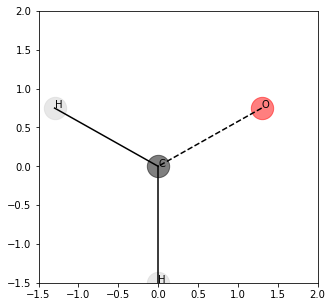

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [3]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
    global elem_lst

    if elem_lst is None:
        print('calculating rdkit element representation lookup table')
        elem_rep_lookup = []
        for elem in elements:
            pt = Chem.GetPeriodicTable() 

            if isinstance(elem, int):
                num=elem
                sym=pt.GetElementSymbol(num)
            else:
                num = pt.GetAtomicNumber(elem)
                sym = elem
            w = pt.GetAtomicWeight(elem)

            Rvdw = pt.GetRvdw(elem)
        #     Rcoval = pt.GetRCovalent(elem)
            valence = pt.GetDefaultValence(elem)
            outer_elec = pt.GetNOuterElecs(elem)

            elem_rep=[num, w,  Rvdw, valence, outer_elec]
#             print(elem_rep)


            elem_rep_lookup.append(elem_rep)
        elem_lst = elem_rep_lookup.copy()
        return elem_rep_lookup
    else:
        return elem_lst




def get_atom_rep(atomic_num, package='rdkit'):
    '''use rdkit or pymatgen to generate atom representation
    '''
    max_elem_num = 118
    element_nums= [x+1 for x in range(max_elem_num)]


    if package =='rdkit':
        elem_lst = lookup_from_rdkit(element_nums)
    elif package == 'pymatgen':
        raise Exception('pymatgen implementation is deprecated.')
        #elem_lst = lookup_from_pymatgen(element_nums)
    else:
        raise Exception('cannot generate atom representation lookup table')

    result = 0
    try:
        result = elem_lst[atomic_num - 1]
    except:
        print(f'error: atomic_num {atomic_num} does not exist')

    return result


def smiles2graph(D, smiles):
    if D==None:
        raise Exception('smiles2grpah() needs to input D to specifiy 2D or 3D graph generation.')
    
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
#     mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)
    
    if D==2:
        rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    if D==3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    
    atom_pos = []
    atom_attr =[]
    
    # get atom attributes and positions
    for i, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        h = get_atom_rep(atomic_num)
    
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
    
    # get bond attributes
    edge_list = []
    edge_attr_list =[]
    for idx, edge in enumerate(mol.GetBonds()):
        i = edge.GetBeginAtomIdx()
        j = edge.GetEndAtomIdx()
        
        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type ==Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type ==Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type ==Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type ==Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]     
            

        edge_list.append((i, j))
        edge_attr_list.append(bond_attr) 
#         print(f'i:{i} j:{j} bond_attr:{bond_attr}')

        edge_list.append((j, i))
        edge_attr_list.append(bond_attr)    
#         print(f'j:{j} j:{i} bond_attr:{bond_attr}')    
    
    x = torch.tensor(atom_attr)
    p = torch.tensor(atom_pos)
    edge_index = torch.tensor(edge_list).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list)
#     print(p)
        
    return x, p, edge_index, edge_attr

smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()


# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
x_focal = None
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        p_focal = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
        x_focal = torch.tensor(h)
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
        
edge_attr = []
for j, edge in enumerate(mol.GetBonds()):
    bond_type = edge.GetBondType()
    if bond_type ==Chem.rdchem.BondType.SINGLE:
        edge_attr.append(1)
    elif bond_type ==Chem.rdchem.BondType.DOUBLE:
        edge_attr.append(2)
    elif bond_type ==Chem.rdchem.BondType.TRIPLE:
        edge_attr.append(3)
    elif bond_type ==Chem.rdchem.BondType.AROMATIC:
        edge_attr.append(4)
edge_attr_neighbor = torch.tensor(edge_attr).unsqueeze(0).T
                              
p_neighbor = torch.tensor(atom_pos)
x_neighbor = torch.tensor(atom_attr)                              
x_focal = x_focal.unsqueeze(0)
# print(p)
# print(origin)
# print(x)
  
    
#============generate a list of same receptive field 
data = Data(p_neighbor=p_neighbor, x_neighbor=x_neighbor, x_focal=x_focal, edge_attr_neighbor=edge_attr_neighbor, p_focal=p_focal)
# print(data)
vis(data=data)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(p_focal, p_neighbor, i)
    data = Data(p = new_p, p_focal = p_focal, x_neighbor=x_neighbor, x_focal = x_focal, edge_attr = edge_attr)
    data_list.append(data)
#     vis(data=data)







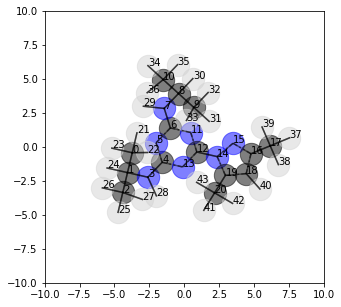

In [4]:
x =torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])  
p = torch.tensor([[-3.7256, -0.4303],                                                                                                                                                                                                [-4.0641, -1.8916],                                                                                                                                                                                                [-4.4027, -3.3529],                                                                                                                                                                                                [-2.6028, -2.2302],                                                                                                                                                                                                [-1.5790, -1.1339],                                                                                                                                                                                                [-2.0164,  0.3008],                                                                                                                                                                                                [-0.9926,  1.3971],                                                                                                                                                                                                [-1.4300,  2.8319],                                                                                                                                                                                                [-0.4062,  3.9281],                                                                                                                                                                                                [ 0.6900,  2.9043],                                                                                                                                                                                                [-1.5024,  4.9520],                                                                                                                                                                                                [ 0.4687,  1.0585],                                                                                                                                                                                                [ 0.9062, -0.3763],                                                                                                                                                                                                [-0.1177, -1.4725],                                                                                                                                                                                                [ 2.3675, -0.7148],                                                                                                                                                                                                [ 3.5003,  0.2684],                                                                                                                                                                                                [ 4.7854, -0.5051],                                                                                                                                                                                                [ 6.1666,  0.0799],                                                                                                                                                                                                [ 4.4469, -1.9664],                                                                                                                                                                                                [ 2.9525, -2.0960],                                                                                                                                                                                                [ 2.1789, -3.3812],                                                                                                                                                                                                [-3.3870,  1.0310],                                                                                                                                                                                                [-2.6322, -0.4120],                                                                                                                                                                                                [-5.1869, -0.0918],                                                                                                                                                                                                [-5.5254, -1.5531],                                                                                                                                                                                                [-4.7412, -4.8142],                                                                                                                                                                                                [-5.8640, -3.0144],                                                                                                                                                                                                [-2.9935, -3.8671],                                                                                                                                                                                                [-1.9937, -3.6010],                                                                                                                                                                                                [-2.9217,  2.9898],                                                                                                                                                                                                [ 0.6176,  5.0244],                                                                                                                                                                                                [ 1.7863,  1.8804],                                                                                                                                                                                                [ 1.7139,  4.0005],                                                                                                                                                                                                [ 0.1592,  1.9483],                                                                                                                                                                                                [-2.5987,  5.9758],                                                                                                                                                                                                [-0.4786,  6.0482],                                                                                                                                                                                                [-2.6523,  3.9887],                                                                                                                                                                                                [ 7.5479,  0.6649],                                                                                                                                                                                                [ 6.7517, -1.3013],                                                                                                                                                                                                [ 5.5816,  1.4611],                                                                                                                                                                                                [ 5.4301, -3.0993],                                                                                                                                                                                                [ 1.4054, -4.6663],                                                                                                                                                                                                [ 3.4641, -4.1547],                                                                                                                                                                                                [ 0.8938, -2.6076]])       
edge_index = torch.tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,                                                                                                                                             8, 10,  6, 11, 11, 12, 12, 13, 12, 14, 14, 15, 15, 16, 16, 17, 16, 18,                                                                                                                                            18, 19, 19, 20, 13,  4, 19, 14,  0, 21,  0, 22,  0, 23,  1, 24,  2, 25,                                                                                                                                             2, 26,  2, 27,  3, 28,  7, 29,  8, 30,  9, 31,  9, 32,  9, 33, 10, 34,                                                                                                                                            10, 35, 10, 36, 17, 37, 17, 38, 17, 39, 18, 40, 20, 41, 20, 42, 20, 43],                                                                                                                                          [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,                                                                                                                                            10,  8, 11,  6, 12, 11, 13, 12, 14, 12, 15, 14, 16, 15, 17, 16, 18, 16,                                                                                                                                            19, 18, 20, 19,  4, 13, 14, 19, 21,  0, 22,  0, 23,  0, 24,  1, 25,  2,                                                                                                                                            26,  2, 27,  2, 28,  3, 29,  7, 30,  8, 31,  9, 32,  9, 33,  9, 34, 10,                                                                                                                                            35, 10, 36, 10, 37, 17, 38, 17, 39, 17, 40, 18, 41, 20, 42, 20, 43, 20]])  
edge_attr = torch.tensor([[1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1]])    
data = Data(x = x, p= p , edge_index= edge_index, edge_attr = edge_attr)
vis_graph(data, lower_bound = -10, upper_bound = 10)



In [20]:
import torch

from torch_geometric.data import Data

from rdkit import Chem
import rdkit
# from rdkit import Chem
# # from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

import pandas as pd
import os

import random


def generate_1hop_kernel(D, typical_compound_smiles, center_atom_id, x_dim=None):
    #     '''
    #     given a typical compound containing a certain kernal, and the center atom id, genrate the kernel
    #     '''
    if D == None:
        raise Exception('generate_kernel2grpah() needs to input D to specifiy 2D or 3D graph generation.')

    smiles = typical_compound_smiles.replace(r'/=', '=')
    smiles = typical_compound_smiles.replace(r'\=', '=')

    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    # mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)

    if D == 2:
        Chem.rdDepictor.Compute2DCoords(mol)
    if D == 3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()

    all_atoms = mol.GetAtoms()
    center_atom = all_atoms[center_atom_id]
    # print(f'center atom:{center_atom.GetSymbol()}')

    atom_pos = []
    atom_attr = []

    supports = center_atom.GetNeighbors()

    if x_dim is None:
        x_center = get_atom_rep(center_atom.GetAtomicNum())
    else:
        x_center = [random.uniform(0, 1) for i in range(x_dim)]

    p_list = []
    x_list = []
    bond_attr_list = []
    # print()
    # print('atom idx:')
    # for i, atom in enumerate(all_atoms):
    #     print(f'{atom.GetIdx()}, {atom.GetSymbol()}')

    for idx, edge in enumerate(center_atom.GetBonds()):
        support_start_id = edge.GetBeginAtomIdx()
        support_end_id = edge.GetEndAtomIdx()
#         print(f'support_start_id:{support_start_id}')
#         print(f'support_end_id:{support_end_id}')
        if (support_start_id == center_atom_id):
            support_id = support_end_id
        else:
            support_id = support_start_id
        support = all_atoms[support_id]
        if x_dim is None:
            x_list.append(get_atom_rep(support.GetAtomicNum()))
        else:
            x_list.append([random.uniform(0, 1) for i in range(x_dim)])
        if D == 2:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y - conf.GetAtomPosition(center_atom_id).y])
        if D == 3:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y -
                                       conf.GetAtomPosition(center_atom_id).y, conf.GetAtomPosition(support_id).z - conf.GetAtomPosition(center_atom_id).z])

        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type == Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]
        bond_attr_list.append(bond_attr)

    x_center = torch.tensor(x_center).unsqueeze(0).unsqueeze(0)
    x_support = torch.tensor(x_list).unsqueeze(0)
    p_support = torch.tensor(p_list).unsqueeze(0)
    edge_attr_support = torch.tensor(bond_attr_list, dtype=p_support.dtype).unsqueeze(0)

#     print('x_center')
#     print(x_center)
#     print('x_support')
#     print(x_support)
#     print('p_support')
#     print(p_support)
#     print('edge_attr_support')
#     print(edge_attr_support)
    data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
    return data  # x_center, x_support, p_support, edge_attr_support


def generate_kernel_with_angle_and_length_and_edge_attr(D, typical_compound_smiles, center_atom_id, x_dim):
    '''
    generate a kernel with typical angle and lenth and edge_attr, but randomize x attribute
    '''
    return generate_1hop_kernel(D, typical_compound_smiles, center_atom_id, x_dim=x_dim)


def read_kernel_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    df = df.transpose()
    kernel_dict = df.to_dict(orient='list')
    return kernel_dict


def print_kernel_files():
    root = 'customized_kernels'
    files = os.listdir(root)
    for file in files:
        df = pd.read_csv(root + '/' + file)
        print(df)


# degree1
hop1_degree1_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel1.csv')

# degree2
hop1_degree2_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel2.csv')


# degree3
hop1_degree3_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel3.csv')


# degree4
hop1_degree4_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel4.csv')


# ===1hop kernels - 2D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_2D_degree1_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_2D_degree2_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_2D_degree3_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_2D_degree4_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]

# ===1hop kernels - 3D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_3D_degree1_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_3D_degree2_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_3D_degree3_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_3D_degree4_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]


def get_hop1_kernel_list(D):
    if D == 2:
        # to make sure the original list is untouched, use the copied one
        return hop1_2D_degree1_kernels_list.copy(), hop1_2D_degree2_kernels_list.copy(), hop1_2D_degree3_kernels_list.copy(), hop1_2D_degree4_kernels_list.copy()
    elif D == 3:
        return hop1_3D_degree1_kernels_list.copy(), hop1_3D_degree2_kernels_list.copy(), hop1_3D_degree3_kernels_list.copy(), hop1_3D_degree4_kernels_list.copy()
    else:
        raise Exception('get_hop1_kernel_list(): invalid D')




In [17]:
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList, CosineSimilarity, Module, ModuleList, Linear, Sigmoid
# from torch.nn import
from torch.nn.parameter import Parameter

from itertools import permutations
import math
import pandas as pd

import os



torch.autograd.set_detect_anomaly(True)

class KernelConv(Module):
    def __init__(self, L=None, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel=None, requires_grad=True, init_length_sc_weight = 0.1, init_angle_sc_weight = 0.5,  init_center_attr_sc_weight = 0.8, init_support_attr_sc_weight = 0.8, init_edge_attr_support_sc_weight=0.8, weight_requires_grad= False):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (L is None) or (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception(
                    'either numer of kernels L, convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center=torch.randn(L, 1, node_attr_dim), x_support=torch.randn(
                    L, num_supports, node_attr_dim), edge_attr_support=torch.randn(L, num_supports, edge_attr_dim), p_support=torch.randn(L, num_supports, D))

        self.num_kernels = init_kernel.x_center.shape[0]

        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor, requires_grad=requires_grad)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor, requires_grad=requires_grad)

        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor, requires_grad=requires_grad)

        p_support_tensor = init_kernel.p_support
#         print(f'p_support_tensor:{p_support_tensor.shape}')
        self.p_support = Parameter(p_support_tensor, requires_grad=requires_grad)

        self.length_sc_weight = Parameter(torch.tensor(init_length_sc_weight), requires_grad = weight_requires_grad)
        self.angle_sc_weight = Parameter(torch.tensor(init_angle_sc_weight), requires_grad = weight_requires_grad)
        self.center_attr_sc_weight = Parameter(torch.tensor(init_center_attr_sc_weight), requires_grad = weight_requires_grad)
        self.support_attr_sc_weight = Parameter(torch.tensor(init_support_attr_sc_weight), requires_grad = weight_requires_grad)
        self.edge_attr_support_sc_weight = Parameter(torch.tensor(init_edge_attr_support_sc_weight), requires_grad = weight_requires_grad)

    def get_num_kernels(self):
        return self.num_kernels

    def permute(self, x):
        #         print('permute')
        #         print('x')
        #         print(x.shape)
        rows = x.shape[1]
        l = [x[:, torch.tensor(permute), :]
             for permute in list(permutations(range(rows)))]
        output = torch.stack(l, dim=1)
#         print('permuted')
#         print(output.shape)
        return output

    def intra_angle(self, p):
        '''
        angles between each row vectors
        '''
        cos = CosineSimilarity(dim=-1)
        new_p = torch.roll(p, 1, dims=-2)
#         print(f'new p:')
#         print(new_p)
        sc = cos(new_p, p)
#         print(f'intra angle sc:{sc.shape}')
        return sc

    def arctan_sc(self, tensor1, tensor2, dim=None):
        diff = torch.square(tensor1 - tensor2)
#         print(diff)
        if dim is not None:
            sc = torch.sum(diff, dim=dim)
        else:
            sc = torch.sum(diff)
        sc = torch.atan(1 / (sc+1e-8))
        return sc

    def get_angle_score(self, p_neighbor, p_support):
        #         print('get_angle_score')
        #         print(f'p_neighbor:{p_neighbor.shape}')
        #         print(p_neighbor.shape)
        #         print(f'p_support:{p_support.shape}')
        #         print(p_support.shape)
        if(p_support.shape[-2] == 1):
            return torch.full((p_support.shape[0], p_neighbor.shape[0]), math.pi / 2, device=p_neighbor.device)
#         cos = CosineSimilarity(dim = 1)

        p_neighbor = p_neighbor.unsqueeze(0).unsqueeze(0).expand(
            p_support.shape[0], p_support.shape[1], p_neighbor.shape[-3], p_neighbor.shape[-2], p_neighbor.shape[-1])
#         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape)
#         print(f'p_neighbor:{p_neighbor.shape}')
        intra_p_neighbor_angle = self.intra_angle(p_neighbor)
#         intra_p_neighbor_dist = intra_p_neighbor_dist.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1])
#         print(f'intra_p_neighbor_dist:{intra_p_neighbor_dist.shape}')

#         p_support = p_support.expand(p_neighbor.shape)
#         print(f'p_support:{p_support.shape}')
        intra_p_support_angle = self.intra_angle(p_support)
#         intra_p_support_dist = intra_p_support_dist.unsqueeze(1).expand(p_support.shape[0], p_neighbor.shape[0],p_support.shape[1])
#         print(f'intra_p_support_dist:{intra_p_support_dist.shape}')

#         sc = cos(intra_p_neighbor_dist, intra_p_support_dist)
#         sc = torch.dot(intra_p_neighbor_dist, intra_p_support_dist.T)
        sc = self.arctan_sc(intra_p_neighbor_angle,
                            intra_p_support_angle, dim=(-1))
#         print(f'inner angle_sc:{sc.shape}')
        return sc.squeeze(1)

    def get_length_score(self, p_neighbor, p_support):
        len_p_neighbor = torch.norm(p_neighbor, dim=-1)
        len_p_support = torch.norm(p_support, dim=-1)

#         print('len_p_neighbor')
#         print(f'len_p_neighbor:{len_p_neighbor.shape}')
#         print(f'len_p_support:{len_p_support.shape}')

        # inverse of L2 norm
        sc = self.arctan_sc(len_p_neighbor, len_p_support, dim=(-1))
#         diff = torch.square(len_p_neighbor - len_p_support)
#         sc = torch.sum(diff)
#         sc = torch.atan(1/sc)

# #         print(sc)
        return sc

    def get_support_attribute_score(self, x_nei, x_support):
        #         print(f'x_nei:{x_nei.shape}')
        #         print(f'x_suppport:{x_support.shape}')
        x_nei = x_nei.unsqueeze(0).unsqueeze(0).expand(
            x_support.shape[0], x_support.shape[1], x_nei.shape[0], x_nei.shape[1], x_nei.shape[2])
        x_support = x_support.unsqueeze(2).expand(x_nei.shape)

        sc = self.arctan_sc(x_nei, x_support, dim=(-2, -1))
        return sc

    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
        #         print(f'center attri:{type(x_focal)}, {type(x_center)}')
        #         print(f'x_focal:{x_focal.shape}, x_center:{x_center.shape}')
        #         print(x_focal)
        #         print(x_center)
        #         diff = torch.square(x_focal - x_center)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        x_focal = x_focal.unsqueeze(0).expand(
            x_center.shape[0], x_focal.shape[0], x_focal.shape[1])
        x_center = x_center.expand(x_focal.shape)
#         print('x_focal')
#         print(x_focal)
#         print('x_center')
#         print(x_center)

        sc = self.arctan_sc(x_focal, x_center, dim=(-1))
        return sc

    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
        #         print('edge_attr_nei')
        #         print(edge_attr_nei)
        #         print('edge_attr_support')
        #         print(edge_attr_support)
        #         diff = torch.square(edge_attr_nei - edge_attr_support)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(edge_attr_nei, edge_attr_support, dim=(-2, -1))
        return sc

    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal.unsqueeze(1)

        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support

        # print('=====cal total sc')
        # print(f'x_center:{x_center.shape}')
        # print(f'x_support:{x_support.shape}')
        # print(f'edge_attr_support:{edge_attr_support.shape}')
        # print(f'p_support:{p_support.shape}')
        # print('\n')
        # print(f'x_focal:{x_focal.shape}')
        # print(f'p_focal:{p_focal.shape}')
        # print(f'x_neighbor:{x_neighbor.shape}')
        # print(f'p_neighbor:{p_neighbor.shape}')
        # print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')

        # because every sub-score is calculated using actan function, which peaks at pi/2, so this max_atn is used to normalized the score so it is in [0,1]
        max_atan = torch.tensor([math.pi / 2], device=p_neighbor.device)

        # calculate the support attribute score
        permuted_x_support = self.permute(x_support)
#         print(f'permuted_x_support:{permuted_x_support.shape}')
        support_attr_sc = self.get_support_attribute_score(x_neighbor, permuted_x_support) / max_atan
#         print(f'support_attr_sc:{support_attr_sc}')
        # get the best support_attr_sc and its index
        best_support_attr_sc, best_support_attr_sc_index = torch.max(support_attr_sc, dim=1)
#         print(f'best_support_attr_sc:{best_support_attr_sc}, index:{best_support_attr_sc_index.shape}')
        # print(f'index:{best_support_attr_sc_index}')

        # calculate the angle score
        permuted_p_support = self.permute(p_support)
        permuted_p_support = permuted_p_support.unsqueeze(2).expand(
            permuted_p_support.shape[0], permuted_p_support.shape[1], best_support_attr_sc_index.shape[1], permuted_p_support.shape[2], permuted_p_support.shape[3])
#         print(f'permuted_p_support:{permuted_p_support}')
        selected_index = best_support_attr_sc_index.unsqueeze(1).unsqueeze(-1).unsqueeze(-1).expand(
            permuted_p_support.shape[0], 1, best_support_attr_sc_index.shape[-1], permuted_p_support.shape[3], permuted_p_support.shape[4])
        best_p_support = torch.gather(permuted_p_support, 1, selected_index)
#         print(f'best_p_support:{best_p_support}')
        angle_sc = self.get_angle_score(p_neighbor, best_p_support) / max_atan
        # print(f'angle_sc.shape:{angle_sc.shape}')

        # calculate length
        best_p_support = best_p_support.squeeze(1)
#         print(f'best_p_support:{best_p_support.shape}')
        length_sc = self.get_length_score(p_neighbor, best_p_support) / max_atan
        # print(f'length_sc.shape:{length_sc.shape}')

        # calculate the center attribute score
#         print(f'x_center:{x_center.shape}')
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center) / max_atan
        # print(f'center_attr_sc.shape:{center_attr_sc.shape}')

        # calculate the edge attribute score
        selected_index = best_support_attr_sc_index.unsqueeze(-1).unsqueeze(-1).expand(
            best_support_attr_sc_index.shape[0], best_support_attr_sc_index.shape[1], edge_attr_support.shape[-2], edge_attr_support.shape[-1])
#         print(f'edge_attr_support:{edge_attr_support.shape}')
        permuted_edge_attr_support = self.permute(edge_attr_support)
#         print(f'permuted:{permuted_edge_attr_support.shape}')
#         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
        best_edge_attr_support = torch.gather(
            permuted_edge_attr_support, 1, selected_index)
#         print(f'best_edge_attr_support:{selected_index.shape}')
#         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')
#         print(f'best_edge_attr_support:{best_edge_attr_support.shape}')
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr_neighbor, best_edge_attr_support) / max_atan
        # print(f'edge_attr_support_sc.shape:{edge_attr_support_sc.shape}')


#         # convert each score to correct dimension
#         angle_sc = angle_sc
#         length_sc = length_sc
        support_attr_sc = best_support_attr_sc  # .unsqueeze(dim=0)
#         center_attr_sc = center_attr_sc
#         edge_attr_support_sc = edge_attr_support_sc

        # the maxium value a arctain function can get

        one = torch.tensor([1], device=p_neighbor.device)
        sc = torch.atan(1 /

                        (torch.square(length_sc - one) * self.length_sc_weight +
                         torch.square(angle_sc - one) * self.angle_sc_weight +
                         torch.square(support_attr_sc - one) * self.support_attr_sc_weight +
                         torch.square(center_attr_sc - one) * self.center_attr_sc_weight +
                         torch.square(edge_attr_support_sc - one) * self.edge_attr_support_sc_weight
                         + 1e-8
                         ))


        # sc = torch.atan(1 /
        #                 (torch.square(length_sc - max_atan) +
        #                  torch.square(angle_sc - max_atan) +
        #                  torch.square(support_attr_sc - max_atan) +
        #                  torch.square(center_attr_sc - max_atan) +
        #                  torch.square(edge_attr_support_sc - max_atan)
        #                  )).squeeze(0)
        sc = sc / max_atan  # normalize the score to be in [0,1]


        return sc, length_sc, angle_sc, support_attr_sc, center_attr_sc, edge_attr_support_sc

    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr_neighbor = kwargv['data'].edge_attr_neighbor
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr_neighbor = kwargv['edge_attr_neighbor']

        if(p_focal.shape[-1] != self.p_support.shape[-1]):
            raise Exception(f'data coordinates is of {p_focal.shape[-1]}D, but the kernel is {self.p_support.shape[-1]}D')


#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(
            x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor)

        # print('\n')
        # print(f'len sc:{length_sc}')
        # print(f'angle sc:{angle_sc}')
        # print(f'support attribute_sc:{supp_attr_sc}')
        # print(f'center_attr_sc:{center_attr_sc}')
        # print(f'edge attribute score:{edge_attr_support_sc}')
        # print(f'total sc: {sc.shape}')
        return sc  # , length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


class BaseKernelSetConv(Module):
    # , trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None, ):
    def __init__(self, fixed_kernelconv1=None, fixed_kernelconv2=None, fixed_kernelconv3=None, fixed_kernelconv4=None, trainable_kernelconv1=None, trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None):
        super(BaseKernelSetConv, self).__init__()

        self.fixed_kernelconv_set = ModuleList([fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3, fixed_kernelconv4])
        self.num_fixed_kernel_list = []
        if (fixed_kernelconv1 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv1.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv2 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv2.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv3 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv3.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv4 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv4.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)

        # if (trainable_kernelconv1 is not None) and (trainable_kernelconv2 is not None) and (trainable_kernelconv3 is not None) and (trainable_kernelconv4 is not None):
        #     self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4]
        #                                                )  # , trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        #     self.num_trainable_kernel_list = [trainable_kernelconv1.get_num_kernels(), trainable_kernelconv2.get_num_kernels(),
        #                                       trainable_kernelconv3.get_num_kernels(), trainable_kernelconv4.get_num_kernels()]
        # else:
        #     self.trainable_kernelconv_set = ModuleList([])
        #     self.num_trainable_kernel_list = []

        self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        self.num_trainable_kernel_list = []
        if (trainable_kernelconv1 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv1.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv2 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv2.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv3 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv3.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv4 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv4.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)

        # num of kernels for each degree, combining both fixed and trainable kerenls
        self.num_kernel_list = []
        for i in range(4):
            num = 0
            if(self.num_fixed_kernel_list[i] is not None):
                num = self.num_fixed_kernel_list[i]
            if(self.num_trainable_kernel_list[i] is not None):
                num += self.num_trainable_kernel_list[i]
            self.num_kernel_list.append(num)



        print(f'self.num_kernel_list:{self.num_kernel_list}')
#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        # print(f'edge_index:{edge_index.shape}, x:{x.shape}')
        deg = degree(edge_index[0], x.shape[0])
        return deg

    def get_neighbor_index(self, edge_index, center_index):
        #         print('edge_index')
        #         print(edge_index)
        #         print('\n')
        #         print('center_index')
        #         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]
        return edge_index[1, d]

    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input=x, dim=0, index=selected_index[0])
        p_focal = torch.index_select(input=p, dim=0, index=selected_index[0])

        return x_focal, p_focal, selected_index[0]

    def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]

        # normalize bond id
        e = (d / 2).long()
#         bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
        bond_id = torch.tensor([2 * x for x in e], device=a.device)
#         print('bond_id')
#         print(bond_id)

        # select bond attributes with the bond id
        nei_edge_attr = torch.index_select(
            input=edge_attr, dim=0, index=bond_id)

        return nei_edge_attr

    def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph

        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
#         print('center_index')
#         print(center_index)

        nei_x_list = []
        nei_p_list = []
        nei_edge_attr_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
#             print(f'nei_index:{nei_index.shape}')

            nei_x = torch.index_select(x, 0, nei_index)
#             print(f'nei_x:{nei_x.shape}')
            nei_p = torch.index_select(p, 0, nei_index)
#             print(f'nei_p:{nei_p.shape}')
            nei_edge_attr = self.get_edge_attr_support_from_center_node(
                edge_attr, edge_index, center_index[i])
#             print('\n nei_edge_attr')
#             print(nei_edge_attr)

            nei_x_list.append(nei_x)
            nei_p_list.append(nei_p)
            nei_edge_attr_list.append(nei_edge_attr)

        nei_x = torch.stack(nei_x_list, dim=0)
        nei_p = torch.stack(nei_p_list, dim=0)
        nei_edge_attr = torch.stack(
            nei_edge_attr_list, dim=0)

#         print('nei_edge_attr')
#         print(nei_edge_attr.shape)

        return nei_x, nei_p, nei_edge_attr

    def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
        x_focal, p_focal, selected_index = self.get_focal_nodes_of_degree(
            deg=deg, x=x, p=p, edge_index=edge_index)

        num_focal = x_focal.shape[0]
        # print(f'num_focal:{num_focal}')
        if num_focal != 0:
            x_neighbor, p_neighbor, edge_attr_neighbor = self.get_neighbor_nodes_and_edges_of_degree(
                deg=deg, x=x, edge_index=edge_index, p=p, edge_attr=edge_attr)
#             print(f'x_neighbor:{x_neighbor.shape}')
#             print(f'p_neighbor:{p_neighbor.shape}')
            return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index
        return None

    def get_reorder_index(self, index):
        '''
        get the index to rearrange output score matrix so that it corespond to the order in the original x matrix

        '''
        rearranged, new_index = torch.sort(index, dim=0)

        return new_index

    def format_output(self, output):
        '''
        change the shape of output from (L, num_nodes, 4) to (num_nodes, 4*L)
        '''
        a = [output[i, :, :] for i in range(output.shape[0])]
        return torch.cat(a, dim=1)

    def save_score(self, sc):
        root = 'customized_kernels'
        print('saving score...')
        sc_np = sc.cpu().detach().numpy()
        files = os.listdir(root)
        headers = []
        for i, file in enumerate(files):
            names = list(pd.read_csv(root + '/' + file)['name'])
            headers += names
            rand_names = ['std_kernel'] * self.num_trainable_kernel_list[i]
            headers += rand_names
        print(headers)
        sc_df = pd.DataFrame(sc_np, columns=headers)
        sc_df = sc_df.transpose()
        sc_df.to_csv('scores.csv')

    def forward(self, *argv, **kwargv):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        if len(argv) != 0:
            raise Exception(
                'Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 2:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
            save_score = kwargv['save_score']

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']

#         print('edge_index')
#         print(edge_index)

#         print('edge_attr')
#         print(edge_attr)

        # loop through all possbile degrees. i.e. 1 to 4 bonds
        sc_list = []
        index_list = []

        # print(f'sum(self.num_kernel_list):{sum(self.num_kernel_list)}')
        zeros = torch.zeros(sum(self.num_kernel_list), x.shape[0], device=p.device)
        # print('zeros')
        # print(zeros)
        start_row_id = 0
        start_col_id = 0
        for deg in range(1, 5):
            # print(f'deg:{deg}')
            receptive_field = self.convert_graph_to_receptive_field(deg, x, p, edge_index, edge_attr)
#             print('receptive_field')
#             print(receptive_field)
            if receptive_field is not None:
                x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index = receptive_field[
                    0], receptive_field[1], receptive_field[2], receptive_field[3], receptive_field[4], receptive_field[5]
                data = Data(x_focal=x_focal, p_focal=p_focal, x_neighbor=x_neighbor,
                            p_neighbor=p_neighbor, edge_attr_neighbor=edge_attr_neighbor)

#                 print(f'selected_index:{selected_index.shape}')
#                 print('====data info====')
#                 print('x_focal')
#                 print(x_focal.shape)
#             print('p_focal')
#             print(p_focal)
#             print('x_neighbor')
#             print(x_neighbor)
#             print('p_neighbor')
#             print(p_neighbor)
#             print('edge_attr_neighbor')
#             print(edge_attr_neighbor)


                # print('===fixed_degree_sc===')
                if self.fixed_kernelconv_set[deg - 1] is not None:
                    fixed_degree_sc = self.fixed_kernelconv_set[deg - 1](data=data)
                    if self.trainable_kernelconv_set[deg - 1] is not None:
                        # print('---trainable_degree_sc---')
                        trainable_degree_sc = self.trainable_kernelconv_set[deg - 1](data=data)
                        # print(f'trianable_degree_sc {trainable_degree_sc.shape}')
                        degree_sc = torch.cat([fixed_degree_sc, trainable_degree_sc])
                    else:
                        degree_sc = fixed_degree_sc
                else:

                    if self.trainable_kernelconv_set[deg - 1] is not None:
                        # print('---trainable_degree_sc---')
                        trainable_degree_sc = self.trainable_kernelconv_set[deg - 1](data=data)
                        # print(f'trianable_degree_sc {trainable_degree_sc.shape}')
                        degree_sc = trainable_degree_sc

                    else:
                        raise Exception (f'both fixed and trainable kernelconv_set are None for degree {deg}')

                zeros[start_row_id:start_row_id + self.num_kernel_list[deg - 1], start_col_id:start_col_id + x_focal.shape[0]] = degree_sc

                index_list.append(selected_index)
                start_row_id += self.num_kernel_list[deg - 1]
                start_col_id += x_focal.shape[0]
            else:

                start_row_id += self.num_kernel_list[deg - 1]

        sc = zeros



        index_list = torch.cat(index_list)

        new_index = self.get_reorder_index(index_list)

        sc = sc[:, new_index]
        sc = sc.T

        # print(f'sc:{sc}')
        if(save_score == True):
            self.save_score(sc)  # save scores for analysis
        return sc


class KernelSetConv(BaseKernelSetConv):
    def __init__(self, L1, L2, L3, L4, D, node_attr_dim, edge_attr_dim):

        self.L = [L1, L2, L3, L4]

    # test of std kernel
        p_support = torch.tensor([[1.2990e+00, 7.5000e-01]]).unsqueeze(0)
        # print(p_support)

        x_center = torch.tensor([[16, 32.067, 1.8, 2, 6]]).unsqueeze(0)

        x_support = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor([[2]], dtype=torch.float).unsqueeze(0)

        kernel1_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

        p_support = torch.tensor([[1.2990e+00, 7.5000e-01],
                                  [-1.2990e+00, 7.5000e-01],
                                  [-2.7756e-16, -1.5000e+00]]).unsqueeze(0)
        # print(p_support)

        x_support = torch.tensor([[16, 32.067, 1.8, 2, 6],
                                  [6.0000, 12.0110, 1.7000, 4.0000, 4.0000],
                                  [1.0000, 1.0080, 1.2000, 1.0000, 1.0000]]).unsqueeze(0)

        x_center = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor(
            [[2], [1], [1]], dtype=torch.float).unsqueeze(0)

        kernel3_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

    #         kernel1 = KernelConv(init_kernel = kernel1_std)
        kernelconv1 = KernelConv(L=L1, D=D, num_supports=1, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv2 = KernelConv(L=L2, D=D, num_supports=2, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)

        kernelconv3 = KernelConv(L=L3, D=D, num_supports=3, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv4 = KernelConv(L=L4, D=D, num_supports=4, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        super(KernelSetConv, self).__init__(kernelconv1, kernelconv2, kernelconv3, kernelconv4)


class Predefined1HopKernelSetConv(BaseKernelSetConv):
    def __init__(self, D, node_attr_dim, edge_attr_dim, L1=0, L2=0, L3=0, L4=0):

        # generate functional kernels
        # degree1 kernels

        fixed_kernel1_list = get_hop1_kernel_list(D)[0]
        trainable_kernel1_list = [fixed_kernel1_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L1 != 0:
            trainable_kernel1_list *= L1  # duplicate the one-member list to have L1 members
            self.trainable_kernel1 = self.cat_kernels(trainable_kernel1_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv1 = KernelConv(init_kernel=self.trainable_kernel1, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv1 = None
        self.fixed_kernel1 = self.cat_kernels(fixed_kernel1_list)
        fixed_kernelconv1 = KernelConv(init_kernel=self.fixed_kernel1, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel1.x_center.shape[0]} degree1 fixed kernels, {L1} degree1 trainable kernels')

        # degree2 kernels
        fixed_kernel2_list = get_hop1_kernel_list(D)[1]
        trainable_kernel2_list = [fixed_kernel2_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L2 != 0:
            trainable_kernel2_list *= L2  # duplicate the one-member list to have L2 members
            self.trainable_kernel2 = self.cat_kernels(trainable_kernel2_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv2 = KernelConv(init_kernel=self.trainable_kernel2, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv2 = None
        self.fixed_kernel2 = self.cat_kernels(fixed_kernel2_list)
        fixed_kernelconv2 = KernelConv(init_kernel=self.fixed_kernel2, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel2.x_center.shape[0]} degree2 fixed kernels, {L2} degree2 trainable kernels')

        # degree3 kernels
        fixed_kernel3_list = get_hop1_kernel_list(D)[2]
        trainable_kernel3_list = [fixed_kernel3_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L3 != 0:
            trainable_kernel3_list *= L3  # duplicate the one-member list to have L3 members
            self.trainable_kernel3 = self.cat_kernels(trainable_kernel3_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv3 = KernelConv(init_kernel=self.trainable_kernel3, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv3 = None
        self.fixed_kernel3 = self.cat_kernels(fixed_kernel3_list)
        fixed_kernelconv3 = KernelConv(init_kernel=self.fixed_kernel3, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel3.x_center.shape[0]} degree3 fixed kernels, {L3} degree3 trainable kernels')

        # degree4 kernels
        fixed_kernel4_list = get_hop1_kernel_list(D)[3]
        trainable_kernel4_list = [fixed_kernel4_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L4 != 0:
            trainable_kernel4_list *= L4  # duplicate the one-member list to have L4 members
            self.trainable_kernel4 = self.cat_kernels(trainable_kernel4_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv4 = KernelConv(init_kernel=self.trainable_kernel4, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv4 = None
        self.fixed_kernel4 = self.cat_kernels(fixed_kernel4_list)
        fixed_kernelconv4 = KernelConv(init_kernel=self.fixed_kernel4, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel4.x_center.shape[0]} degree4 fixed kernels, {L4} degree4 trainable kernels')

        super(Predefined1HopKernelSetConv, self).__init__(fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3,
                                                          fixed_kernelconv4, trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4)

    def cat_kernels(self, kernel_list):
        x_center_list = [kernel.x_center for kernel in kernel_list]
        x_support_list = [kernel.x_support for kernel in kernel_list]
        p_support_list = [kernel.p_support for kernel in kernel_list]
        edge_attr_support_list = [kernel.edge_attr_support for kernel in kernel_list]

        # for x_center in x_center_list:
        #     print(x_center.shape)
        x_center = torch.cat(x_center_list)
        x_support = torch.cat(x_support_list)
        p_support = torch.cat(p_support_list)
        edge_attr_support = torch.cat(edge_attr_support_list)
        data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
        return data

    def get_num_kernel(self):
        num_trainable_kernel = 0
        if hasattr(self, 'trainable_kernel1'):
            num_trainable_kernel = self.trainable_kernel1.x_center.shape[0]
        if hasattr(self, 'trainable_kernel2'):
            num_trainable_kernel += self.trainable_kernel2.x_center.shape[0]
        if hasattr(self, 'trainable_kernel3'):
            num_trainable_kernel += self.trainable_kernel3.x_center.shape[0]
        if hasattr(self, 'trainable_kernel4'):
            num_trainable_kernel += self.trainable_kernel4.x_center.shape[0]

        total_num = self.fixed_kernel1.x_center.shape[0] + self.fixed_kernel2.x_center.shape[0] + self.fixed_kernel3.x_center.shape[0] + self.fixed_kernel4.x_center.shape[0] + num_trainable_kernel
        # print(f'total number kernels:{total_num}')
        return total_num

class PredefinedNHopKernelSetConv(BaseKernelSetConv):
    '''
    The main difference between a PredefinedNHopKernelSetConv(abbreviated as NHop for simplicity) and Predefined1HopKernelSetConv(abbreviated as 1Hop for simplicity)
    is that 1HOP has some fixed kernels but NHop has all trainable but predefined kernels.
    '''
    def __init__(self, D, node_attr_dim, edge_attr_dim, L1=0, L2=0, L3=0, L4=0):

        # generate functional kernels
        # degree1 kernels
        typical_smiles = 'C[H]'
        typical_center_atom_id = 1
        trainable_kernel1_list = []
        if L1 != 0:
            for i in range(L1):
                trainable_kernel1 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel1_list.append(trainable_kernel1)
            self.trainable_kernel1 = self.cat_kernels(trainable_kernel1_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv1 = KernelConv(init_kernel=self.trainable_kernel1, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv1 = None
        print(f'PredefinedNHopKernelSetConv: there are {L1} degree1 trainable kernels')


        # degree2 kernels
        # degree2 kernels
        typical_smiles = 'CO[H]'
        typical_center_atom_id = 1
        trainable_kernel2_list = []
        if L2 != 0:
            for i in range(L2):
                trainable_kernel2 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel2_list.append(trainable_kernel2)
            self.trainable_kernel2 = self.cat_kernels(trainable_kernel2_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv2 = KernelConv(init_kernel=self.trainable_kernel2, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv2 = None
        print(f'PredefinedNHopKernelSetConv: there are {L2} degree2 trainable kernels')

        # degree3 kernels
        typical_smiles = 'C=C'
        typical_center_atom_id = 1
        trainable_kernel3_list = []
        if L3 != 0:
            for i in range(L3):
                trainable_kernel3 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel3_list.append(trainable_kernel3)
            self.trainable_kernel3 = self.cat_kernels(trainable_kernel3_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv3 = KernelConv(init_kernel=self.trainable_kernel3, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv3 = None
        print(f'PredefinedNHopKernelSetConv: there are {L3} degree3 trainable kernels')

        # degree4 kernels
        typical_smiles = 'CC'
        typical_center_atom_id = 1
        trainable_kernel4_list = []
        if L4 != 0:
            for i in range(L4):
                trainable_kernel4 = generate_kernel_with_angle_and_length_and_edge_attr(D, typical_smiles, typical_center_atom_id, node_attr_dim)
                trainable_kernel4_list.append(trainable_kernel4)
            self.trainable_kernel4 = self.cat_kernels(trainable_kernel4_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv4 = KernelConv(init_kernel=self.trainable_kernel4, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv4 = None
        print(f'PredefinedNHopKernelSetConv: there are {L4} degree4 trainable kernels')

        super(PredefinedNHopKernelSetConv, self).__init__(trainable_kernelconv1=trainable_kernelconv1, trainable_kernelconv2=trainable_kernelconv2, trainable_kernelconv3=trainable_kernelconv3, trainable_kernelconv4=trainable_kernelconv4)

    def cat_kernels(self, kernel_list):
        x_center_list = [kernel.x_center for kernel in kernel_list]
        x_support_list = [kernel.x_support for kernel in kernel_list]
        p_support_list = [kernel.p_support for kernel in kernel_list]
        edge_attr_support_list = [kernel.edge_attr_support for kernel in kernel_list]

        # for x_center in x_center_list:
        #     print(x_center.shape)
        x_center = torch.cat(x_center_list)
        x_support = torch.cat(x_support_list)
        p_support = torch.cat(p_support_list)
        edge_attr_support = torch.cat(edge_attr_support_list)
        data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
        return data

    def get_num_kernel(self):
        num_trainable_kernel = 0
        if hasattr(self, 'trainable_kernel1'):
            num_trainable_kernel = self.trainable_kernel1.x_center.shape[0]
        if hasattr(self, 'trainable_kernel2'):
            num_trainable_kernel += self.trainable_kernel2.x_center.shape[0]
        if hasattr(self, 'trainable_kernel3'):
            num_trainable_kernel += self.trainable_kernel3.x_center.shape[0]
        if hasattr(self, 'trainable_kernel4'):
            num_trainable_kernel += self.trainable_kernel4.x_center.shape[0]

        total_num = num_trainable_kernel
        # print(f'total number kernels:{total_num}')
        return total_num

# class KernelLayer(Module):
#     '''
#         a wrapper of KernelSetConv for clear input/output dimension, inputs:
#         D: dimension
#         L: number of KernelConvSet

#         the output will be of dimension L1+L2+L3+L4
#     '''

#     def __init__(self, x_dim, p_dim, edge_dim, L1=None, L2=None, L3=None, L4=None, predined_kernelsets=True):

#         super(KernelLayer, self).__init__()
#         if(predined_kernelsets == True):
#             self.conv = PredefinedKernelSetConv(D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)
#         else:
#             if L1 is None or L2 is None or L3 is None or L4 is None:
#                 raise Exception('KernelLayer(): if predined_kernelsets is false, then L1-L4 needs to be specified')
#             self.conv = KernelSetConv(L1, L2, L3, L4, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_dim)

#     def forward(self, data):
#         return self.conv(data=data)



In [8]:
# model.py
import torch
from torch.nn import ModuleList
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
from torch_geometric.data import Data, DataLoader


class MolGCN(MessagePassing):
    def __init__(self, num_layers=5, num_kernel1=None, num_kernel2=None, num_kernel3=None, num_kernel4=None, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1):
        super(MolGCN, self).__init__(aggr='add')
        self.num_layers = num_layers
        if num_layers < 1:
            raise Exception('at least one convolution layer is needed')

        self.layers = ModuleList()

        self.num_kernerls_list = []
        # first layer
        if (num_kernel1 is not None) and (num_kernel2 is not None) and (num_kernel3 is not None) and (num_kernel4 is not None) and (predined_kernelsets == False):
            kernel_layer = KernelSetConv(num_kernel1, num_kernel2, num_kernel3, num_kernel4, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim)
            num_kernels = num_kernel1 + num_kernel2 + num_kernel3 + num_kernel4
        elif (predined_kernelsets == True):
            kernel_layer = Predefined1HopKernelSetConv(D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim, L1=num_kernel1, L2=num_kernel2, L3=num_kernel3, L4=num_kernel4)
            num_kernels = kernel_layer.get_num_kernel()
        else:
            raise Exception('MolGCN: num_kernel1-4 need to be specified')

        self.layers.append(kernel_layer)
        self.num_kernerls_list.append(num_kernels)

        # second_layer
        # x_dim = num_kernels
        # for i in range(num_layers - 1):
        #     kernel_layer = KernelLayer(x_dim, p_dim, edge_attr_dim, num_kernel1, num_kernel2, num_kernel3, num_kernel4)
        #     self.layers.append(kernel_layer)

    def num_kernels(self, layer):
        return self.num_kernerls_list[layer]

    def forward(self, *argv, **kwargv):
        if len(argv) != 0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']
            data = Data(x=x, p=p, edge_index=edge_index, edge_attr=edge_attr)
            # print(f'foward: data.x{data.x}')
            save_score = kwargv['save_score']
        h = x

        for i in range(self.num_layers):
            print(f'{i}th layer')
            data.x = h

            kernel_layer = self.layers[i]
            sim_sc = kernel_layer(data=data, save_score=save_score)
            # print(f'edge_index:{edge_index.device}, sim_sc:{sim_sc.device}')
            # print('sim_sc')
            # print(sim_sc)
            h = self.propagate(edge_index=edge_index, sim_sc=sim_sc)
            # print(f'h:{h}')
        return h

    def message(self, sim_sc_j):
        # print(f'sim_sc_j:{sim_sc_j.shape}')
        return sim_sc_j


class GNN_graphpred(torch.nn.Module):
    """
    Extension of GIN to incorporate edge information by concatenation.
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        num_tasks (int): number of tasks in multi-task learning scenario
        drop_ratio (float): dropout rate
        JK (str): last, concat, max or sum.
        graph_pooling (str): sum, mean, max, attention, set2set
        gnn_type: gin, gcn, graphsage, gat
    See https://arxiv.org/abs/1810.00826
    JK-net: https://arxiv.org/abs/1806.03536
    """

    def __init__(self, num_layers=1, num_kernel1=0, num_kernel2=0, num_kernel3=0, num_kernel4=0, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1, JK="last", drop_ratio=0, graph_pooling="mean"):
        super(GNN_graphpred, self).__init__()
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.D = p_dim

        if self.num_layers < 1:
            raise ValueError("GNN_graphpred: Number of GNN layers must be greater than 0.")

        self.gnn = MolGCN(num_layers=num_layers, num_kernel1=num_kernel1, num_kernel2=num_kernel2, num_kernel3=num_kernel3,
                          num_kernel4=num_kernel4, x_dim=x_dim, p_dim=p_dim, edge_attr_dim=edge_attr_dim, predined_kernelsets=predined_kernelsets)

        # Different kind of graph pooling
        if graph_pooling == "sum":
            self.pool = global_add_pool
        elif graph_pooling == "mean":
            self.pool = global_mean_pool
        elif graph_pooling == "max":
            self.pool = global_max_pool
        # elif graph_pooling == "attention":
        #     if self.JK == "concat":
        #         self.pool = GlobalAttention(gate_nn=torch.nn.Linear(
        #             (self.num_layer + 1) * emb_dim, 1))
        #     else:
        #         self.pool = GlobalAttention(
        #             gate_nn=torch.nn.Linear(emb_dim, 1))
        # elif graph_pooling[:-1] == "set2set":
        #     set2set_iter = int(graph_pooling[-1])
        #     if self.JK == "concat":
        #         self.pool = Set2Set((self.num_layer + 1)
        #                             * emb_dim, set2set_iter)
        #     else:
        #         self.pool = Set2Set(emb_dim, set2set_iter)
        else:
            raise ValueError("Invalid graph pooling type.")

        # For graph-level binary classification
        if graph_pooling[:-1] == "set2set":
            self.mult = 2
        else:
            self.mult = 1

        if self.JK == "concat":
            self.graph_pred_linear = torch.nn.Linear(
                self.mult * (self.num_layers + 1) * self.emb_dim, 1)
        else:
            self.graph_pred_linear = torch.nn.Linear(self.gnn.num_kernels(-1), 1)

    def from_pretrained(self, model_file):
        # self.gnn = GNN(self.num_layer, self.emb_dim, JK = self.JK, drop_ratio = self.drop_ratio)
        self.gnn.load_state_dict(torch.load(model_file))

    def save_kernellayer(self, path):
        layers = self.gnn.layers
        print(f'{self.D}D, there are {len(layers)} layers')
        for i, layer in enumerate(layers):
            print(f'saving {i}th layer')
            torch.save(layer.state_dict(), f'{path}/{i}th_layer.pth')

    def forward(self, *argv, save_score=False):
        if len(argv) == 5:
            x, p, edge_index, edge_attr, batch = argv[0], argv[1], argv[2], argv[3], argv[4]
        elif len(argv) == 1:
            data = argv[0]
            x, p, edge_index, edge_attr, batch = data.x, data.p, data.edge_index, data.edge_attr, data.batch
        else:
            raise ValueError("unmatched number of arguments.")

        node_representation = self.gnn(x=x, edge_index=edge_index, edge_attr=edge_attr, p=p, save_score=save_score)
        # print(f'node_rep:{node_representation.shape}')
        graph_representation = self.pool(node_representation, batch)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'linear layer shape:{self.graph_pred_linear}')
        pred = self.graph_pred_linear(graph_representation)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'pred.grad:{pred.grad}')
        return pred, graph_representation




In [ ]:
# reset kernel

# data prep
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print_data(data)

# manual data for weird angle testing
trans = torch.tensor([[1,1]])
# x= torch.tensor([[1],[1],[1],[1],[1],[1]], dtype = torch.float)
x= torch.tensor([[1],[1],[1],[1],[1]], dtype = torch.float)
# p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [0,0], [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1],[0,0],[0,2]])#, [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p+=trans
# edge_index = torch.tensor([[0,3,1,3,2,3, 5,2,2,4],[3,0,3,1,3,2,2,5,4,2]])
edge_index = torch.tensor([[0,3,1,3,2,3, 4,2],[3,0,3,1,3,2,2,4]])
# edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])
edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1]])
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)

# ========generate a list of graphs
origin = torch.tensor([0,0])
vis_graph(data)
data_list = []
for i in range(0, 370, 10):
    data = graph_rotate(data, origin, i)
    data_list.append(data)
#     vis_graph(data)


# model prep
node_attr_dim = x.shape[1]
edge_attr_dim = edge_attr.shape[1]
model = KernelSetConv(L=10, D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)


# examine the model kernel
# x_center = model.state_dict()['kernel_set.2.x_center']
# x_support = model.state_dict()['kernel_set.2.x_support']
# edge_attr_support = model.state_dict()['kernel_set.2.edge_attr_support']
# p_support = model.state_dict()['kernel_set.2.p_support']
# m_kernel = Data(x_center= x_center, x_support = x_support, edge_attr_support = edge_attr_support, p_support = p_support)
# vis_kernel(m_kernel) # this visualize one single kernel
# # vis_kernel_in_model(model) # this visualize all kernels in the model


# run
# model(data = data)


# KernelConv test

In [ ]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random
from tqdm import tqdm

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.5)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss


def train():
    random.shuffle(data_list)
    for data in data_list:
#         vis_graph(data)
#         sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = model(data=data)
        sc = model(data=data)
        label = torch.tensor([math.pi/2], dtype= torch.float)
        loss = criterion(sc, label)
        optimizer.zero_grad()
        
#         print('before')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
            
        loss.backward()
        optimizer.step()
        
#         print('after')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
        
    print('\n')
    print(f'loss:{loss.item()}')
#     print(f'len sc:{length_sc.item()}')
#     print(f'angle sc:{angle_sc.item()}')
#     print(f'support attribute_sc:{supp_attr_sc.item()}')
#     print(f'edge attribute score:{edge_attr_support_sc.item()}')
    print(f'label:{label}')
    print(f'total sc: {sc}')    

for i in range(20):
    print(f'========epoch {i}========')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_support_origin)
    


In [ ]:
vis_kernel_in_model(model)

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [ ]:
# test of getting neighbor_index from center_index
import torch
# tensor = torch.randint(15,(2,4), dtype=torch.long)
# print('tensor:')
# print(tensor)

# print('\n')
# print('values')
# values = torch.arange(10, dtype=torch.long)
# print(values)

# print('\n')
# a = tensor[0]

# print(a)
# b = a.unsqueeze(1) == values
# print(b)
# c = b.nonzero()
# print(c)
# d = c[:,0]
# print(d)
# tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

# print(f'a:{a}')

edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8], [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
print(edge_index)
nei_index = torch.tensor([1,3,8])
print(nei_index)
edge_attr = torch.tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

def get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]

    # normalize bond id
    e = (d/2).long()
    bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
    
    # select bond attributes with the bond id
    nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)
    
    return nei_edge_attr
center_index = torch.tensor([2])

a = get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index)
print(a)

In [ ]:
# visualize individual customized kernel
smiles = 'Cc1ccccc1'
center_atom_id =2

kernel = generate_1hop_kernel(2, smiles, center_atom_id)
# print(kernel)
# print(kernel.x_center.dtype, kernel.x_support.dtype, kernel.p_support.dtype, kernel.edge_attr_support.dtype)
vis_kernel(kernel, vis_element=True, only_graph=True)

x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True
# mol = Chem.MolFromSmiles(smiles, sanitize= False)
# mol.UpdatePropertyCache(strict=False)
# mol=Chem.AddHs(mol)
# mol


In [ ]:
# visualize all kernels in files
import os
root = 'customized_kernels'
files = os.listdir(root)
for file in files:
    path = root + '/' + file
    
    kernel_dict = read_kernel_from_csv(path)
    for key, value in kernel_dict.items():
        smiles = value[0]
        center_atom_id = value[1]
        kernel = generate_1hop_kernel(2, smiles, center_atom_id)
        vis_kernel(kernel, vis_element=True, only_graph=True)

In [ ]:

smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

model = GNN_graphpred()

In [6]:
# test of imbalance handling
from torch.utils.data import WeightedRandomSampler


numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print(f'target train 0/1: {len(np.where(target == 0)[0])} {len(np.where(target == 1)[0])}')

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print(f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")    
     



target train 0/1: 900 100


NameError: name 'DataLoader' is not defined

PredefinedNHopKernelSetConv: there are 15 degree1 trainable kernels
PredefinedNHopKernelSetConv: there are 15 degree2 trainable kernels
PredefinedNHopKernelSetConv: there are 15 degree3 trainable kernels
PredefinedNHopKernelSetConv: there are 15 degree4 trainable kernels
self.num_kernel_list:[15, 15, 15, 15]
['trainable_kernelconv_set.0.x_center', 'trainable_kernelconv_set.0.x_support', 'trainable_kernelconv_set.0.edge_attr_support', 'trainable_kernelconv_set.0.p_support', 'trainable_kernelconv_set.0.length_sc_weight', 'trainable_kernelconv_set.0.angle_sc_weight', 'trainable_kernelconv_set.0.center_attr_sc_weight', 'trainable_kernelconv_set.0.support_attr_sc_weight', 'trainable_kernelconv_set.0.edge_attr_support_sc_weight', 'trainable_kernelconv_set.1.x_center', 'trainable_kernelconv_set.1.x_support', 'trainable_kernelconv_set.1.edge_attr_support', 'trainable_kernelconv_set.1.p_support', 'trainable_kernelconv_set.1.length_sc_weight', 'trainable_kernelconv_set.1.angle_sc_weight', 'train

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:213: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


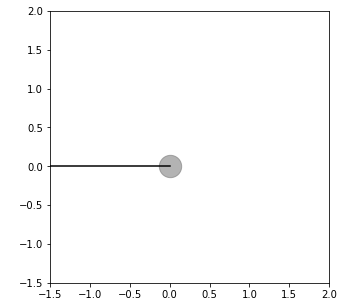

====0th kernel info====
0th-p_support:
torch.Size([1, 2])


0th-x_support:
tensor([[1.2215e+00, 5.7322e-01, 5.9438e-01, 5.9577e-01, 5.9483e-01, 3.7154e-01,
         2.7390e-01, 4.2303e-01, 3.9593e-01, 4.0605e-01, 4.0803e-01, 4.1869e-01,
         4.0836e-01, 4.0912e-01, 4.0105e-01, 4.0225e-01, 4.2172e-01, 4.2212e-01,
         4.0049e-01, 4.0597e-01, 4.1261e-01, 4.0158e-01, 2.1679e-03, 2.1681e-03,
         4.6455e-03, 1.1765e-03, 2.3978e-03, 2.6984e-03, 2.4809e-03, 1.3746e-03,
         1.3093e-03, 1.4342e-03, 2.1863e-03, 2.1807e-03, 2.1924e-03, 2.2069e-03,
         1.2234e-03, 2.3003e-03, 1.3692e-03, 1.3783e-03, 1.7262e-03, 2.3668e-03,
         2.2336e-03, 1.4763e-03, 3.8038e-01, 4.2267e-01, 5.2268e-01, 4.8458e-01,
         3.9074e-01, 4.0095e-01, 3.9397e-01, 3.9561e-01, 5.1849e-01, 3.4333e-01,
         3.0563e-01, 5.1778e-01, 4.7520e-01, 4.3269e-01, 5.2659e-01, 5.4842e-01,
         5.4128e-01, 5.4109e-01, 5.5349e-01, 5.4239e-01, 5.7569e-01, 5.5114e-01,
         5.2372e-01, 5.3717e-01, 5

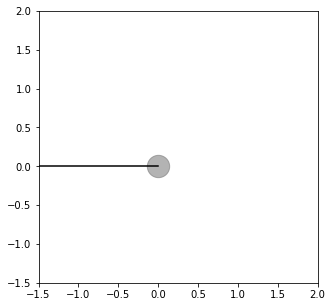

====1th kernel info====
1th-p_support:
torch.Size([1, 2])


1th-x_support:
tensor([[ 3.0116e+00,  1.7172e+00,  1.7258e+00,  1.7160e+00,  1.7159e+00,
          1.5063e+00,  1.9052e+00,  1.4507e+00,  1.3164e+00,  1.4105e+00,
          1.4032e+00,  1.4339e+00,  1.3992e+00,  1.4131e+00,  1.3622e+00,
          1.3529e+00,  1.4537e+00,  1.4556e+00,  1.3715e+00,  1.3559e+00,
          1.4295e+00,  1.3924e+00,  3.3577e-04, -2.4759e-03, -2.2506e-03,
          2.2417e-03,  1.1055e-02,  7.8717e-03,  1.4011e-03,  2.0514e-03,
          3.3437e-03,  1.4866e-02,  6.4440e-03, -9.3595e-04,  1.3518e-03,
          5.3737e-03,  4.4312e-03, -1.1211e-02, -2.3475e-03,  2.4867e-03,
          5.9619e-03,  2.3275e-02,  6.6479e-03,  1.8514e-03,  3.2059e-01,
          4.7861e-01,  2.8323e-01,  2.6065e-01,  3.3364e-01,  3.2195e-01,
          3.3041e-01,  3.3328e-01,  5.2028e-01,  3.1612e-01,  2.4156e-01,
          2.8433e-01,  2.9702e-01,  3.8009e-01,  3.0081e-01,  3.0561e-01,
          3.0216e-01,  3.0421e-01,  3

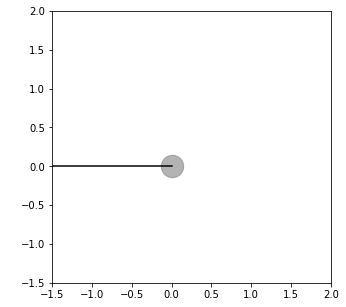

====2th kernel info====
2th-p_support:
torch.Size([1, 2])


2th-x_support:
tensor([[ 3.5727e-01,  4.6603e-01,  4.9005e-01,  4.8780e-01,  4.8328e-01,
          1.4793e+00, -4.5450e-01,  2.4009e-01,  2.3249e-01,  2.5075e-01,
          2.5023e-01,  2.5005e-01,  2.4976e-01,  2.5354e-01,  2.5002e-01,
          2.4930e-01,  2.3789e-01,  2.4346e-01,  2.5110e-01,  2.4819e-01,
          2.4647e-01,  2.5255e-01, -4.8705e-03,  3.4895e-03, -3.9173e-03,
         -3.5287e-03, -1.2111e-03,  5.9344e-03,  1.3597e-02, -1.1302e-03,
         -4.6372e-05, -4.0220e-04, -4.7273e-04, -6.3625e-04,  1.7608e-04,
          4.1955e-04, -8.1011e-06,  1.1750e-03, -8.0471e-04, -8.7948e-04,
          1.3509e-03,  6.4299e-04,  3.0995e-04, -4.4326e-04,  4.0639e-01,
          3.9255e-01,  2.7015e-01,  2.2388e-01,  3.1908e-01,  3.2235e-01,
          3.2209e-01,  3.2408e-01,  1.4920e+00,  7.2813e-01,  3.3381e-01,
          2.7053e-01,  1.6734e-01,  7.3045e-01,  3.8897e-01,  3.8771e-01,
          3.8869e-01,  3.8809e-01,  3

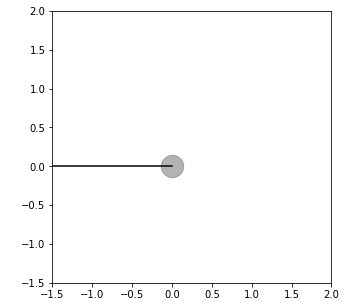

====3th kernel info====
3th-p_support:
torch.Size([1, 2])


3th-x_support:
tensor([[ 3.2957e-01,  4.7478e-01,  4.9039e-01,  4.8798e-01,  4.8410e-01,
          1.4925e+00, -4.5801e-01,  2.5026e-01,  2.4322e-01,  2.6146e-01,
          2.6094e-01,  2.5990e-01,  2.6048e-01,  2.6374e-01,  2.6080e-01,
          2.6020e-01,  2.4817e-01,  2.5372e-01,  2.6188e-01,  2.5878e-01,
          2.5724e-01,  2.6283e-01, -5.2212e-03,  2.3730e-03, -6.3798e-03,
         -4.4882e-03, -2.4605e-03,  3.7114e-03,  1.3813e-02, -2.0248e-03,
         -1.8541e-03, -1.9308e-03, -1.2908e-03, -1.3136e-03, -1.6729e-03,
         -1.6847e-03, -1.8410e-03, -1.3470e-03, -1.2001e-03, -1.7004e-03,
         -1.3064e-03, -9.1499e-04, -1.1925e-03, -1.7871e-03,  4.1728e-01,
          3.6770e-01,  2.7235e-01,  2.2714e-01,  3.2110e-01,  3.2340e-01,
          3.2407e-01,  3.2591e-01,  1.4455e+00,  7.0117e-01,  3.3249e-01,
          2.7117e-01,  1.7595e-01,  6.8353e-01,  3.9370e-01,  3.9284e-01,
          3.9385e-01,  3.9332e-01,  3

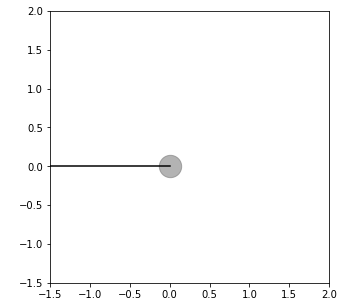

====4th kernel info====
4th-p_support:
torch.Size([1, 2])


4th-x_support:
tensor([[1.2222, 0.5734, 0.5947, 0.5961, 0.5951, 0.3726, 0.2722, 0.4224, 0.3956,
         0.4054, 0.4074, 0.4180, 0.4078, 0.4085, 0.4005, 0.4018, 0.4211, 0.4215,
         0.3999, 0.4055, 0.4120, 0.4009, 0.0021, 0.0025, 0.0044, 0.0016, 0.0024,
         0.0027, 0.0042, 0.0021, 0.0020, 0.0018, 0.0012, 0.0021, 0.0021, 0.0022,
         0.0019, 0.0021, 0.0021, 0.0021, 0.0013, 0.0020, 0.0021, 0.0020, 0.3802,
         0.4238, 0.5224, 0.4839, 0.3904, 0.4004, 0.3936, 0.3952, 0.5185, 0.3422,
         0.3055, 0.5174, 0.4749, 0.4332, 0.5259, 0.5477, 0.5405, 0.5404, 0.5527,
         0.5417, 0.5754, 0.5502, 0.5231, 0.5366, 0.5702, 0.5524, 0.5387, 0.5111,
         0.5403, 0.6399, 0.7711, 0.5315, 0.6502, 0.2874, 0.4074, 0.4049, 0.4065,
         0.4069, 0.4188, 0.4629, 0.4077, 0.4114, 0.3991, 0.4148, 0.4183, 0.4663,
         0.4041, 0.4064, 0.4056]])


4th-x_center:
tensor([[-1.1034e-17, -1.8418e-12,  3.3956e-14,  3.0164e-16,  1.

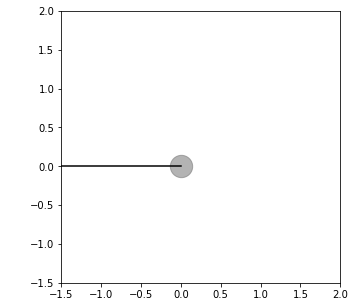

====5th kernel info====
5th-p_support:
torch.Size([1, 2])


5th-x_support:
tensor([[ 0.5798, -1.2038, -0.4533, -0.5491, -0.8506, -1.2449, -0.6463,  0.1695,
         -0.2623, -0.0631, -0.7551, -0.2394, -0.0802, -0.7337, -0.8681, -0.2188,
          0.0610, -0.0709, -0.1680, -0.3639, -0.2534, -0.3349,  2.7974,  2.7522,
          2.9921,  2.6854,  2.7489,  2.6619,  2.6535,  2.8042,  2.7603,  2.7047,
          2.8118,  2.7063,  2.7504,  2.8361,  2.8932,  2.7914,  2.7444,  2.8624,
          2.8604,  2.8778,  2.7041,  2.7009,  2.1618,  3.1377,  2.3176,  1.7854,
          2.1334,  2.3215,  2.1470,  1.8507, -2.2115, -2.6049, -3.1721,  2.1823,
         -2.5544, -2.2892,  2.2133,  2.4441,  2.3904,  2.4712,  2.4037,  2.5315,
          1.9738,  2.4927,  2.3384,  2.4553,  2.3570,  2.2663,  1.8233,  2.4386,
          2.1072, -2.4088, -2.2880, -2.9353, -2.3320, -2.8697, -2.6797, -2.6323,
         -2.4885, -2.6626, -2.6301, -2.6890, -2.7015, -2.6656, -2.6049, -2.5937,
         -2.6893, -2.5643, -2.6251

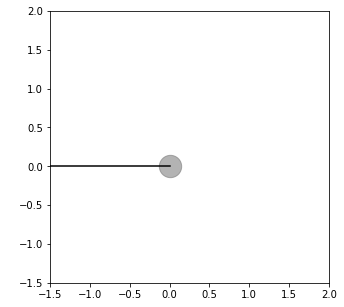

====6th kernel info====
6th-p_support:
torch.Size([1, 2])


6th-x_support:
tensor([[1.2221e+00, 5.7309e-01, 5.9435e-01, 5.9574e-01, 5.9479e-01, 3.7086e-01,
         2.7436e-01, 4.2321e-01, 3.9614e-01, 4.0624e-01, 4.0822e-01, 4.1887e-01,
         4.0855e-01, 4.0932e-01, 4.0124e-01, 4.0244e-01, 4.2190e-01, 4.2230e-01,
         4.0069e-01, 4.0617e-01, 4.1280e-01, 4.0178e-01, 2.1892e-03, 1.1361e-03,
         4.5250e-03, 1.3982e-03, 2.6228e-03, 1.7675e-03, 4.6476e-03, 2.2605e-03,
         2.2634e-03, 2.3618e-03, 1.8677e-03, 2.3349e-03, 1.2625e-03, 1.9763e-03,
         1.3163e-03, 1.4680e-03, 2.0659e-03, 2.1397e-03, 1.3018e-03, 1.6379e-03,
         2.0882e-03, 2.2471e-03, 3.7984e-01, 4.2248e-01, 5.2245e-01, 4.8418e-01,
         3.9055e-01, 4.0082e-01, 3.9379e-01, 3.9544e-01, 5.1795e-01, 3.4337e-01,
         3.0550e-01, 5.1754e-01, 4.7531e-01, 4.3271e-01, 5.2645e-01, 5.4833e-01,
         5.4124e-01, 5.4092e-01, 5.5337e-01, 5.4226e-01, 5.7563e-01, 5.5111e-01,
         5.2363e-01, 5.3706e-01, 5

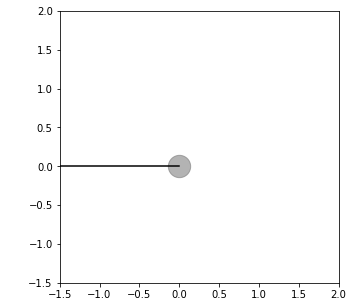

====7th kernel info====
7th-p_support:
torch.Size([1, 2])


7th-x_support:
tensor([[-0.1153, -1.7011, -1.1893, -1.3290, -1.3497, -1.4186,  3.5689, -0.7549,
         -0.7134, -0.9627, -0.8799, -1.1150, -1.2851, -1.1336, -0.9724, -0.9365,
         -0.7207, -0.9541, -0.8417, -0.7983, -1.0869, -0.9154,  2.8276,  2.8212,
         -2.7688, -2.9370,  2.8562, -2.8736,  2.8240, -3.0221, -2.4825, -2.8446,
          2.8453,  2.8275, -2.2535,  2.8328, -2.6287,  2.8409, -2.9646,  2.8505,
          2.8309,  2.8501,  2.8314,  2.8224,  2.5402,  3.1328,  2.6613,  2.1603,
          1.7511,  2.2162, -1.4453,  2.3752, -2.1031, -2.5759, -3.1842,  2.0727,
         -3.1096, -2.3956,  2.7272,  2.7866,  2.7854,  2.7907,  2.7651,  2.8014,
          2.6484,  2.7702,  2.7710,  2.7481,  2.7679,  2.7099,  2.5540,  2.7312,
          2.4968,  1.7383,  1.3601, -2.9005, -2.0454, -2.9132, -2.5126, -2.5016,
         -2.4819, -2.4537, -2.3768, -2.5147, -2.6069, -2.3422, -2.3425,  1.4151,
         -2.3863, -2.4290, -2.4761

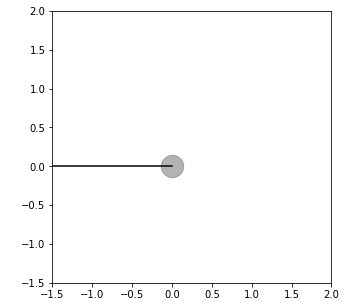

====8th kernel info====
8th-p_support:
torch.Size([1, 2])


8th-x_support:
tensor([[ 6.0663e-01,  4.6978e-01,  4.9967e-01,  4.9679e-01,  4.9233e-01,
          1.3679e+00, -4.6167e-01,  2.3236e-01,  2.2548e-01,  2.3956e-01,
          2.3946e-01,  2.3953e-01,  2.3842e-01,  2.4091e-01,  2.3907e-01,
          2.3864e-01,  2.3013e-01,  2.3421e-01,  2.3967e-01,  2.3629e-01,
          2.3579e-01,  2.3936e-01, -5.2790e-03,  2.0140e-03, -6.5494e-03,
         -4.3544e-03, -3.0073e-05,  3.8522e-03,  1.2152e-02, -1.4289e-03,
          3.4456e-05,  4.2368e-04, -1.1983e-03, -1.0374e-03, -1.8105e-03,
         -1.5507e-03,  4.2455e-04, -1.1435e-03, -1.8633e-03, -1.0684e-03,
         -1.2768e-03,  7.0953e-04,  5.0845e-04, -1.2312e-03,  3.9496e-01,
          3.8474e-01,  2.6098e-01,  2.1323e-01,  3.1036e-01,  3.1372e-01,
          3.1375e-01,  3.1581e-01,  1.4026e+00,  6.8685e-01,  3.2904e-01,
          2.5995e-01,  1.5285e-01,  7.3006e-01,  3.7949e-01,  3.7735e-01,
          3.7964e-01,  3.7797e-01,  3

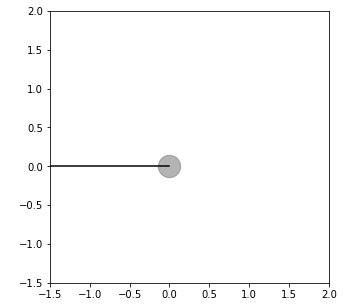

====9th kernel info====
9th-p_support:
torch.Size([1, 2])


9th-x_support:
tensor([[1.2210e+00, 5.7297e-01, 5.9409e-01, 5.9549e-01, 5.9455e-01, 3.7226e-01,
         2.7563e-01, 4.2286e-01, 3.9569e-01, 4.0588e-01, 4.0787e-01, 4.1852e-01,
         4.0819e-01, 4.0896e-01, 4.0088e-01, 4.0208e-01, 4.2155e-01, 4.2195e-01,
         4.0033e-01, 4.0579e-01, 4.1245e-01, 4.0143e-01, 2.1824e-03, 2.3415e-03,
         4.0776e-03, 1.1931e-03, 2.2463e-03, 1.6242e-03, 4.1906e-03, 2.0185e-03,
         1.9609e-03, 2.0382e-03, 2.1004e-03, 1.8632e-03, 2.0223e-03, 2.0899e-03,
         1.9850e-03, 1.9691e-03, 1.4182e-03, 1.2256e-03, 2.0561e-03, 2.1101e-03,
         1.9888e-03, 2.0287e-03, 3.8107e-01, 4.2213e-01, 5.2288e-01, 4.8505e-01,
         3.9077e-01, 4.0102e-01, 3.9399e-01, 3.9563e-01, 5.1922e-01, 3.4341e-01,
         3.0583e-01, 5.1796e-01, 4.7500e-01, 4.3313e-01, 5.2661e-01, 5.4854e-01,
         5.4130e-01, 5.4116e-01, 5.5358e-01, 5.4241e-01, 5.7582e-01, 5.5126e-01,
         5.2375e-01, 5.3719e-01, 5

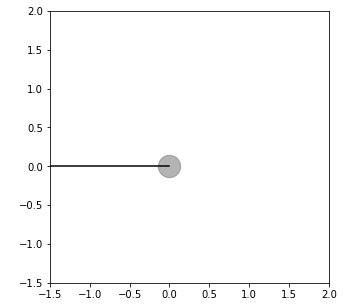

====10th kernel info====
10th-p_support:
torch.Size([1, 2])


10th-x_support:
tensor([[1.2211e+00, 5.7336e-01, 5.9431e-01, 5.9572e-01, 5.9479e-01, 3.7326e-01,
         2.7682e-01, 4.2266e-01, 3.9548e-01, 4.0565e-01, 4.0765e-01, 4.1828e-01,
         4.0797e-01, 4.0872e-01, 4.0064e-01, 4.0186e-01, 4.2135e-01, 4.2174e-01,
         4.0009e-01, 4.0557e-01, 4.1223e-01, 4.0117e-01, 2.2651e-03, 2.6590e-03,
         4.8388e-03, 1.6172e-03, 2.5541e-03, 2.7291e-03, 4.5558e-03, 1.3052e-03,
         2.1244e-03, 2.1816e-03, 1.3562e-03, 2.3266e-03, 1.2343e-03, 1.2860e-03,
         1.2935e-03, 1.3230e-03, 1.3216e-03, 1.2201e-03, 2.3212e-03, 2.2534e-03,
         2.1818e-03, 2.0535e-03, 3.8243e-01, 4.2200e-01, 5.2323e-01, 4.8569e-01,
         3.9094e-01, 4.0126e-01, 3.9416e-01, 3.9579e-01, 5.2045e-01, 3.4332e-01,
         3.0610e-01, 5.1833e-01, 4.7468e-01, 4.3344e-01, 5.2693e-01, 5.4881e-01,
         5.4163e-01, 5.4153e-01, 5.5387e-01, 5.4282e-01, 5.7615e-01, 5.5154e-01,
         5.2411e-01, 5.3760e-01

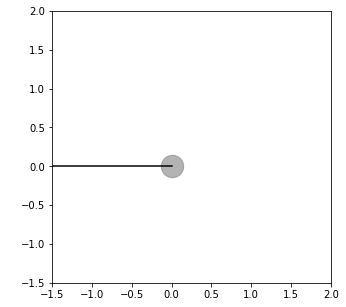

====11th kernel info====
11th-p_support:
torch.Size([1, 2])


11th-x_support:
tensor([[ 5.0654e-01,  4.6520e-01,  4.9416e-01,  4.9146e-01,  4.8697e-01,
          1.4098e+00, -4.5238e-01,  2.3444e-01,  2.2723e-01,  2.4297e-01,
          2.4261e-01,  2.4270e-01,  2.4180e-01,  2.4487e-01,  2.4219e-01,
          2.4153e-01,  2.3218e-01,  2.3700e-01,  2.4296e-01,  2.3992e-01,
          2.3906e-01,  2.4349e-01, -5.3689e-03,  2.2194e-03, -1.5527e-03,
         -4.1673e-03,  1.5598e-03,  4.9287e-03,  1.0583e-02, -1.3418e-03,
         -1.4276e-03, -1.1268e-03, -1.8174e-04, -1.2026e-03, -1.2095e-03,
         -9.5772e-04, -1.4507e-03, -9.4693e-04, -1.0971e-03, -1.1411e-03,
         -1.8982e-04, -8.8430e-04,  1.7313e-07, -1.3655e-03,  3.9702e-01,
          3.9509e-01,  2.6988e-01,  2.2207e-01,  3.1695e-01,  3.2024e-01,
          3.2009e-01,  3.2208e-01,  1.4588e+00,  7.1194e-01,  3.3158e-01,
          2.7049e-01,  1.5543e-01,  7.4622e-01,  3.8405e-01,  3.8234e-01,
          3.8403e-01,  3.8281e-01,

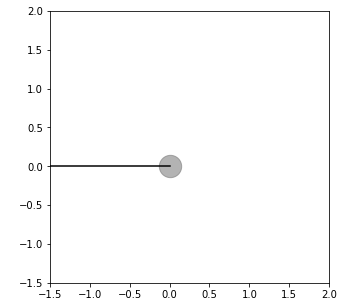

====12th kernel info====
12th-p_support:
torch.Size([1, 2])


12th-x_support:
tensor([[1.2242e+00, 5.7376e-01, 5.9525e-01, 5.9663e-01, 5.9568e-01, 3.7046e-01,
         2.7330e-01, 4.2263e-01, 3.9604e-01, 4.0561e-01, 4.0765e-01, 4.1819e-01,
         4.0799e-01, 4.0866e-01, 4.0072e-01, 4.0201e-01, 4.2130e-01, 4.2168e-01,
         4.0015e-01, 4.0577e-01, 4.1216e-01, 4.0107e-01, 2.0809e-03, 2.1051e-03,
         3.3398e-03, 4.2474e-04, 2.3861e-03, 2.3512e-03, 5.1973e-03, 1.7836e-03,
         1.7361e-03, 1.9839e-03, 1.8457e-03, 1.7885e-03, 2.1276e-03, 2.1837e-03,
         1.8696e-03, 1.8632e-03, 1.1637e-03, 2.1506e-03, 1.9977e-03, 2.2704e-03,
         2.0064e-03, 1.7324e-03, 3.7936e-01, 4.2435e-01, 5.2216e-01, 4.8343e-01,
         3.9001e-01, 4.0007e-01, 3.9323e-01, 3.9487e-01, 5.1841e-01, 3.4162e-01,
         3.0499e-01, 5.1714e-01, 4.7497e-01, 4.3348e-01, 5.2575e-01, 5.4761e-01,
         5.4046e-01, 5.4011e-01, 5.5252e-01, 5.4163e-01, 5.7533e-01, 5.5038e-01,
         5.2301e-01, 5.3656e-01

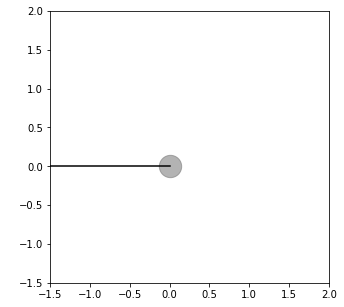

====13th kernel info====
13th-p_support:
torch.Size([1, 2])


13th-x_support:
tensor([[1.2249e+00, 5.7345e-01, 5.9513e-01, 5.9648e-01, 5.9552e-01, 3.6744e-01,
         2.7340e-01, 4.2366e-01, 3.9686e-01, 4.0670e-01, 4.0870e-01, 4.1930e-01,
         4.0904e-01, 4.0977e-01, 4.0176e-01, 4.0298e-01, 4.2234e-01, 4.2273e-01,
         4.0120e-01, 4.0671e-01, 4.1326e-01, 4.0223e-01, 2.1929e-03, 1.1447e-03,
         4.6747e-03, 1.0553e-03, 2.2883e-03, 1.7692e-03, 2.3314e-03, 1.7074e-03,
         2.1283e-03, 2.0605e-03, 1.8517e-03, 1.8882e-03, 1.7874e-03, 1.5011e-03,
         2.1601e-03, 2.3467e-03, 2.1676e-03, 1.8741e-03, 2.2397e-03, 1.9021e-03,
         1.8380e-03, 2.0493e-03, 3.7697e-01, 4.2406e-01, 5.2143e-01, 4.8241e-01,
         3.8994e-01, 4.0010e-01, 3.9318e-01, 3.9485e-01, 5.1629e-01, 3.4266e-01,
         3.0471e-01, 5.1657e-01, 4.7586e-01, 4.3295e-01, 5.2581e-01, 5.4766e-01,
         5.4062e-01, 5.4000e-01, 5.5251e-01, 5.4162e-01, 5.7498e-01, 5.5045e-01,
         5.2289e-01, 5.3646e-01

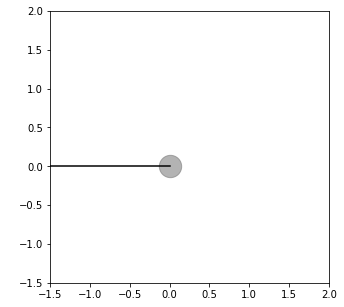

====14th kernel info====
14th-p_support:
torch.Size([1, 2])


14th-x_support:
tensor([[1.2213e+00, 5.7333e-01, 5.9447e-01, 5.9585e-01, 5.9492e-01, 3.7256e-01,
         2.7484e-01, 4.2305e-01, 3.9595e-01, 4.0607e-01, 4.0805e-01, 4.1870e-01,
         4.0838e-01, 4.0914e-01, 4.0107e-01, 4.0228e-01, 4.2174e-01, 4.2213e-01,
         4.0051e-01, 4.0599e-01, 4.1263e-01, 4.0160e-01, 2.1826e-03, 1.4653e-03,
         4.6677e-03, 1.5724e-03, 2.3046e-03, 2.3004e-03, 4.7185e-03, 1.2782e-03,
         1.1995e-03, 2.1750e-03, 2.0639e-03, 1.2417e-03, 1.2623e-03, 1.9299e-03,
         1.2196e-03, 1.5888e-03, 2.2404e-03, 2.2826e-03, 2.3267e-03, 1.9875e-03,
         2.1084e-03, 1.9709e-03, 3.8059e-01, 4.2243e-01, 5.2276e-01, 4.8475e-01,
         3.9072e-01, 4.0097e-01, 3.9396e-01, 3.9560e-01, 5.1899e-01, 3.4341e-01,
         3.0570e-01, 5.1786e-01, 4.7517e-01, 4.3295e-01, 5.2661e-01, 5.4848e-01,
         5.4137e-01, 5.4113e-01, 5.5353e-01, 5.4247e-01, 5.7575e-01, 5.5124e-01,
         5.2380e-01, 5.3725e-01

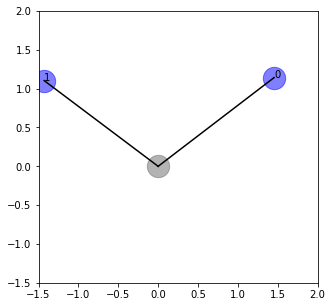

====0th kernel info====
0th-p_support:
torch.Size([2, 2])


0th-x_support:
tensor([[ 1.9972e+00,  1.1287e+00,  1.1267e+00,  1.1261e+00,  1.1262e+00,
          9.9707e-01,  1.2417e+00,  9.5981e-01,  9.2529e-01,  9.2840e-01,
          9.2216e-01,  9.4888e-01,  9.2137e-01,  9.2937e-01,  8.9479e-01,
          8.9226e-01,  9.5953e-01,  9.5787e-01,  8.9894e-01,  8.9739e-01,
          9.3915e-01,  9.1819e-01,  6.0334e-01,  3.9472e-01,  1.0352e+00,
          2.9500e-01,  3.7210e-01,  3.2917e-01,  5.3804e-01,  3.0985e-01,
          3.1157e-01,  3.1250e-01,  3.1215e-01,  3.1456e-01,  3.0874e-01,
          3.1427e-01,  3.1175e-01,  3.1226e-01,  3.1329e-01,  3.1248e-01,
          3.1095e-01,  3.1159e-01,  3.1339e-01,  3.1060e-01, -1.3724e-02,
         -1.4192e-02,  2.0050e-02,  5.4968e-03,  2.6360e-02,  1.2755e-02,
          2.6096e-02,  2.5981e-02, -1.5972e-02,  1.9868e-02,  2.0547e-02,
          1.9724e-02,  1.8689e-02, -1.4113e-02,  2.2574e-02,  2.4615e-02,
          2.5913e-02,  2.6467e-02,  2

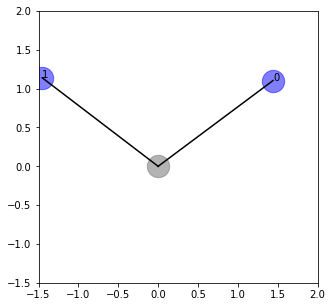

====1th kernel info====
1th-p_support:
torch.Size([2, 2])


1th-x_support:
tensor([[ 2.0003e+00,  1.1429e+00,  1.1416e+00,  1.1412e+00,  1.1411e+00,
          1.0170e+00,  1.2549e+00,  9.5738e-01,  9.1977e-01,  9.2433e-01,
          9.2593e-01,  9.4323e-01,  9.2388e-01,  9.2420e-01,  9.0607e-01,
          9.0621e-01,  9.5764e-01,  9.5551e-01,  9.0712e-01,  9.1095e-01,
          9.3554e-01,  9.1158e-01,  6.0440e-01,  4.1175e-01,  1.0363e+00,
          2.9049e-01,  3.6154e-01,  3.2742e-01,  5.3780e-01,  2.9760e-01,
          2.9673e-01,  3.0054e-01,  3.0025e-01,  3.0083e-01,  2.9519e-01,
          3.0121e-01,  2.9799e-01,  2.9839e-01,  3.0300e-01,  2.9988e-01,
          2.9921e-01,  3.0012e-01,  3.0116e-01,  2.9880e-01,  1.8076e-03,
          1.1395e-02,  9.1902e-03,  2.6436e-02,  9.3046e-03,  1.2409e-02,
          1.0202e-02,  1.0241e-02, -5.1113e-03, -2.6536e-02, -5.1234e-04,
         -2.9786e-02, -2.7532e-02, -2.8409e-02,  5.7413e-03,  1.6818e-03,
          3.9549e-03,  2.2631e-03,  2

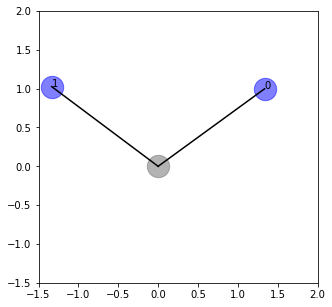

====2th kernel info====
2th-p_support:
torch.Size([2, 2])


2th-x_support:
tensor([[ 2.0132e+00,  1.1492e+00,  1.1482e+00,  1.1478e+00,  1.1477e+00,
          1.0072e+00,  1.2618e+00,  9.5607e-01,  8.9206e-01,  9.2424e-01,
          9.2766e-01,  9.4587e-01,  9.2697e-01,  9.2614e-01,  9.1043e-01,
          9.1251e-01,  9.5564e-01,  9.5459e-01,  9.1063e-01,  9.1679e-01,
          9.3729e-01,  9.1405e-01,  6.0973e-01,  4.0230e-01,  1.0619e+00,
          2.9110e-01,  3.5625e-01,  3.2581e-01,  5.0497e-01,  3.0257e-01,
          3.0488e-01,  3.0764e-01,  3.0480e-01,  3.0666e-01,  3.0277e-01,
          3.0581e-01,  3.0691e-01,  3.0627e-01,  3.0702e-01,  3.0772e-01,
          3.0627e-01,  3.0778e-01,  3.0632e-01,  3.0564e-01, -5.3628e-03,
         -2.1704e-03, -5.4581e-03, -7.2661e-03, -9.4644e-04, -1.0991e-03,
         -4.7540e-04, -4.7725e-04,  8.6517e-05, -7.3276e-04, -3.5435e-03,
         -5.7637e-03, -2.5864e-03,  7.4089e-04, -4.5593e-03, -4.4009e-03,
         -4.3519e-03, -4.3646e-03, -4

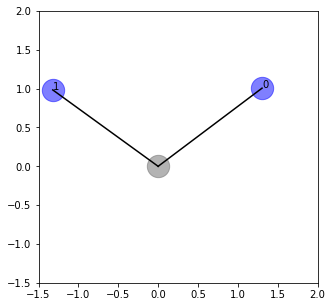

====3th kernel info====
3th-p_support:
torch.Size([2, 2])


3th-x_support:
tensor([[ 2.0022e+00,  1.1410e+00,  1.1399e+00,  1.1396e+00,  1.1395e+00,
          9.9403e-01,  1.2557e+00,  9.5060e-01,  8.8791e-01,  9.1859e-01,
          9.2188e-01,  9.3942e-01,  9.2094e-01,  9.1996e-01,  9.0436e-01,
          9.0622e-01,  9.5031e-01,  9.4898e-01,  9.0463e-01,  9.1062e-01,
          9.3137e-01,  9.0769e-01,  6.0879e-01,  4.0418e-01,  1.0605e+00,
          2.9477e-01,  3.5977e-01,  3.2765e-01,  5.0529e-01,  3.0559e-01,
          3.0729e-01,  3.1020e-01,  3.0785e-01,  3.0898e-01,  3.0545e-01,
          3.0894e-01,  3.0986e-01,  3.0946e-01,  3.1000e-01,  3.1041e-01,
          3.0949e-01,  3.1025e-01,  3.1005e-01,  3.0839e-01,  7.1424e-03,
          2.0477e-03,  1.2624e-03, -2.5387e-04,  5.9555e-03,  6.0327e-03,
          6.3105e-03,  6.2992e-03,  2.4841e-03,  1.4306e-03,  2.0016e-03,
          1.0905e-03,  3.6502e-03,  4.0661e-03,  1.7844e-03,  2.1200e-03,
          2.2976e-03,  2.3245e-03,  2

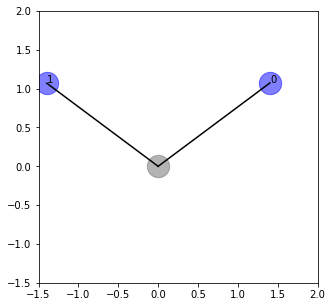

====4th kernel info====
4th-p_support:
torch.Size([2, 2])


4th-x_support:
tensor([[ 2.0078e+00,  1.1446e+00,  1.1436e+00,  1.1432e+00,  1.1432e+00,
          9.9705e-01,  1.2596e+00,  9.5202e-01,  8.8780e-01,  9.2032e-01,
          9.2387e-01,  9.4218e-01,  9.2337e-01,  9.2247e-01,  9.0702e-01,
          9.0919e-01,  9.5147e-01,  9.5043e-01,  9.0712e-01,  9.1328e-01,
          9.3338e-01,  9.1050e-01,  6.0835e-01,  4.0580e-01,  1.0599e+00,
          2.9457e-01,  3.5743e-01,  3.2813e-01,  5.0524e-01,  3.0451e-01,
          3.0673e-01,  3.0932e-01,  3.0682e-01,  3.0847e-01,  3.0462e-01,
          3.0787e-01,  3.0920e-01,  3.0832e-01,  3.0919e-01,  3.0974e-01,
          3.0847e-01,  3.0948e-01,  3.0848e-01,  3.0782e-01,  6.9137e-03,
         -1.1488e-03,  4.8396e-03,  4.1712e-03,  4.9368e-03,  5.9907e-03,
          5.0068e-03,  5.1069e-03,  7.6469e-05,  7.8166e-04,  2.8545e-03,
          4.3411e-03,  6.4319e-03,  3.2472e-03,  3.5411e-03,  3.5423e-03,
          3.7756e-03,  3.9393e-03,  3

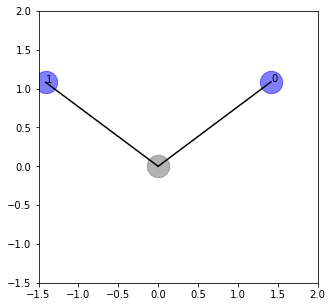

====5th kernel info====
5th-p_support:
torch.Size([2, 2])


5th-x_support:
tensor([[ 2.0022e+00,  1.1411e+00,  1.1400e+00,  1.1396e+00,  1.1395e+00,
          9.9663e-01,  1.2550e+00,  9.5053e-01,  8.8643e-01,  9.1881e-01,
          9.2227e-01,  9.4024e-01,  9.2146e-01,  9.2061e-01,  9.0506e-01,
          9.0717e-01,  9.5010e-01,  9.4901e-01,  9.0528e-01,  9.1120e-01,
          9.3177e-01,  9.0857e-01,  6.0882e-01,  4.0394e-01,  1.0603e+00,
          2.9503e-01,  3.5571e-01,  3.2805e-01,  5.0563e-01,  3.0382e-01,
          3.0589e-01,  3.0854e-01,  3.0612e-01,  3.0762e-01,  3.0389e-01,
          3.0708e-01,  3.0825e-01,  3.0764e-01,  3.0847e-01,  3.0876e-01,
          3.0772e-01,  3.0864e-01,  3.0778e-01,  3.0682e-01,  3.3145e-03,
          3.8874e-03,  6.6629e-03,  3.5112e-03,  5.4236e-03,  6.6997e-03,
          5.4648e-03,  5.4594e-03, -9.0108e-04,  3.9029e-03,  4.6230e-03,
          6.5350e-03,  8.0206e-03,  3.5592e-03,  4.5540e-03,  4.4986e-03,
          4.8494e-03,  4.6168e-03,  4

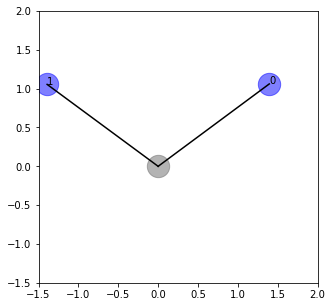

====6th kernel info====
6th-p_support:
torch.Size([2, 2])


6th-x_support:
tensor([[ 2.0019e+00,  1.1416e+00,  1.1405e+00,  1.1401e+00,  1.1401e+00,
          9.9795e-01,  1.2553e+00,  9.5053e-01,  8.8762e-01,  9.1880e-01,
          9.2247e-01,  9.4032e-01,  9.2190e-01,  9.2087e-01,  9.0567e-01,
          9.0808e-01,  9.4998e-01,  9.4885e-01,  9.0572e-01,  9.1192e-01,
          9.3180e-01,  9.0879e-01,  6.1025e-01,  4.0400e-01,  1.0640e+00,
          2.9293e-01,  3.5580e-01,  3.2629e-01,  5.0195e-01,  3.0605e-01,
          3.0773e-01,  3.1060e-01,  3.0812e-01,  3.0948e-01,  3.0591e-01,
          3.0918e-01,  3.1019e-01,  3.0970e-01,  3.1035e-01,  3.1068e-01,
          3.0984e-01,  3.1073e-01,  3.0981e-01,  3.0863e-01,  3.5910e-03,
          3.0814e-04,  3.2002e-03,  1.9525e-03,  3.5986e-03,  3.8585e-03,
          3.6693e-03,  3.6614e-03,  2.4443e-03,  2.9879e-03,  2.9930e-03,
          2.9921e-03,  4.8561e-03,  4.4672e-03,  2.3821e-03,  2.5209e-03,
          2.7170e-03,  2.6633e-03,  2

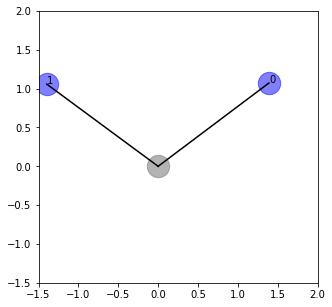

====7th kernel info====
7th-p_support:
torch.Size([2, 2])


7th-x_support:
tensor([[ 2.0313e+00,  1.1576e+00,  1.1568e+00,  1.1564e+00,  1.1563e+00,
          1.0094e+00,  1.2743e+00,  9.6278e-01,  8.9768e-01,  9.3075e-01,
          9.3428e-01,  9.5281e-01,  9.3392e-01,  9.3286e-01,  9.1747e-01,
          9.1951e-01,  9.6226e-01,  9.6120e-01,  9.1741e-01,  9.2380e-01,
          9.4390e-01,  9.2081e-01,  6.0874e-01,  4.0088e-01,  1.0615e+00,
          2.8997e-01,  3.5539e-01,  3.2828e-01,  5.0506e-01,  3.0234e-01,
          3.0398e-01,  3.0711e-01,  3.0458e-01,  3.0591e-01,  3.0220e-01,
          3.0538e-01,  3.0632e-01,  3.0608e-01,  3.0675e-01,  3.0706e-01,
          3.0599e-01,  3.0721e-01,  3.0624e-01,  3.0502e-01, -3.8061e-03,
          7.8012e-04, -2.8250e-03, -5.0412e-03, -7.6393e-04, -9.2767e-04,
         -4.9397e-04, -5.3931e-04, -7.9657e-04,  1.4962e-03, -1.9694e-03,
         -2.6927e-03, -2.0299e-03, -4.7247e-04, -1.8979e-03, -1.8917e-03,
         -1.9043e-03, -2.0046e-03, -1

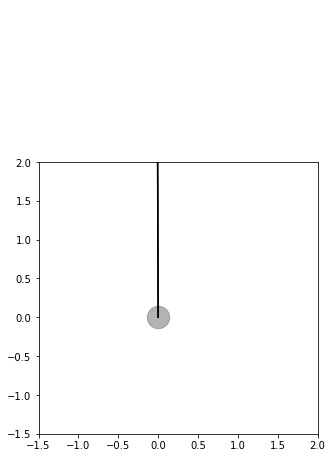

====8th kernel info====
8th-p_support:
torch.Size([2, 2])


8th-x_support:
tensor([[ 2.0123e+00,  1.1634e+00,  1.1618e+00,  1.1617e+00,  1.1614e+00,
          1.0232e+00,  1.2655e+00,  9.6473e-01,  9.1374e-01,  9.2993e-01,
          9.3258e-01,  9.4179e-01,  9.3785e-01,  9.3165e-01,  9.0841e-01,
          9.0030e-01,  9.6274e-01,  9.5332e-01,  9.1363e-01,  9.0566e-01,
          9.4124e-01,  9.1738e-01,  5.9429e-01,  4.0619e-01,  1.0292e+00,
          3.0154e-01,  3.6945e-01,  3.4079e-01,  5.4589e-01,  3.1424e-01,
          3.1549e-01,  3.1558e-01,  3.1683e-01,  3.1751e-01,  3.1421e-01,
          3.1775e-01,  3.2026e-01,  3.1492e-01,  3.1872e-01,  3.1900e-01,
          3.1713e-01,  3.1782e-01,  3.1824e-01,  3.1726e-01,  1.4097e-02,
          1.6230e-02, -9.1718e-03,  4.7409e-04, -1.8648e-03,  1.1865e-03,
         -9.2390e-04, -8.9706e-04, -1.0983e-03,  3.1905e-03,  2.2064e-03,
         -9.2332e-03, -5.7919e-03,  1.5331e-02, -7.5346e-03, -7.7367e-03,
         -1.0159e-02, -9.7897e-03, -8

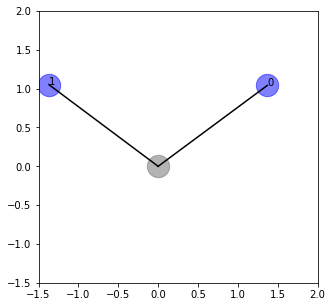

====9th kernel info====
9th-p_support:
torch.Size([2, 2])


9th-x_support:
tensor([[ 2.0095e+00,  1.1452e+00,  1.1441e+00,  1.1438e+00,  1.1436e+00,
          9.9847e-01,  1.2607e+00,  9.5313e-01,  8.8878e-01,  9.2134e-01,
          9.2481e-01,  9.4310e-01,  9.2413e-01,  9.2338e-01,  9.0767e-01,
          9.0983e-01,  9.5268e-01,  9.5165e-01,  9.0786e-01,  9.1387e-01,
          9.3443e-01,  9.1134e-01,  6.1035e-01,  4.0467e-01,  1.0620e+00,
          2.9430e-01,  3.5749e-01,  3.2704e-01,  5.0561e-01,  3.0402e-01,
          3.0590e-01,  3.0876e-01,  3.0645e-01,  3.0766e-01,  3.0400e-01,
          3.0731e-01,  3.0854e-01,  3.0815e-01,  3.0881e-01,  3.0899e-01,
          3.0789e-01,  3.0884e-01,  3.0821e-01,  3.0694e-01,  2.8000e-03,
         -2.6209e-03,  7.5279e-04, -3.2210e-03,  3.2149e-03,  3.1217e-03,
          3.3648e-03,  3.3511e-03, -1.4665e-03, -1.0049e-03, -1.7338e-03,
          3.4279e-04,  3.1573e-03,  1.5578e-03,  8.4430e-04,  1.2561e-03,
          1.3952e-03,  1.4302e-03,  1

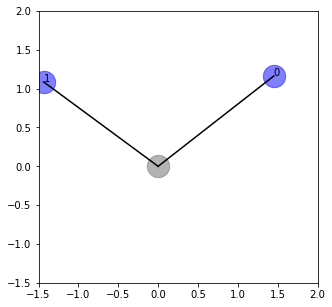

====10th kernel info====
10th-p_support:
torch.Size([2, 2])


10th-x_support:
tensor([[ 1.9930e+00,  1.1273e+00,  1.1245e+00,  1.1240e+00,  1.1239e+00,
          1.0018e+00,  1.2366e+00,  9.6176e-01,  9.2986e-01,  9.3020e-01,
          9.2980e-01,  9.4844e-01,  9.3105e-01,  9.3097e-01,  9.0519e-01,
          8.9905e-01,  9.6051e-01,  9.5767e-01,  9.0914e-01,  9.0470e-01,
          9.4131e-01,  9.1993e-01,  6.0123e-01,  4.1783e-01,  1.0328e+00,
          3.1682e-01,  3.7335e-01,  3.3103e-01,  5.4051e-01,  3.1144e-01,
          3.1299e-01,  3.1456e-01,  3.1692e-01,  3.1744e-01,  3.1023e-01,
          3.1682e-01,  3.1307e-01,  3.1409e-01,  3.1564e-01,  3.1636e-01,
          3.1530e-01,  3.1412e-01,  3.1833e-01,  3.1731e-01, -4.0166e-03,
         -1.2170e-02,  1.5032e-02,  9.5830e-03,  2.0549e-02,  8.8114e-03,
          2.0540e-02,  2.0092e-02, -1.2838e-02,  3.1056e-02,  1.8674e-02,
          1.4845e-02,  9.4645e-03, -9.5211e-03,  1.5835e-02,  1.6751e-02,
          1.8241e-02,  1.8068e-02,

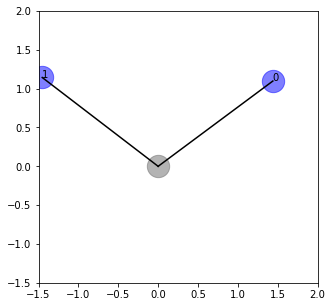

====11th kernel info====
11th-p_support:
torch.Size([2, 2])


11th-x_support:
tensor([[ 1.9676e+00,  1.1250e+00,  1.1223e+00,  1.1217e+00,  1.1218e+00,
          9.9279e-01,  1.2309e+00,  9.6582e-01,  9.2791e-01,  9.3329e-01,
          9.3705e-01,  9.4780e-01,  9.3697e-01,  9.3415e-01,  9.1031e-01,
          9.0225e-01,  9.6363e-01,  9.5818e-01,  9.1560e-01,  9.0763e-01,
          9.4516e-01,  9.2206e-01,  6.0431e-01,  4.1087e-01,  1.0361e+00,
          2.9239e-01,  3.7241e-01,  3.2744e-01,  5.3757e-01,  3.0439e-01,
          3.0456e-01,  3.0784e-01,  3.0656e-01,  3.0773e-01,  3.0314e-01,
          3.0739e-01,  3.0551e-01,  3.0714e-01,  3.0773e-01,  3.0710e-01,
          3.0711e-01,  3.0751e-01,  3.0768e-01,  3.0556e-01,  2.0481e-02,
          8.9798e-05,  5.1522e-04,  2.1483e-02,  1.4101e-02,  3.0811e-02,
          1.6011e-02,  1.6246e-02,  4.8718e-03,  1.2191e-02,  1.9066e-02,
          8.3464e-04,  1.7171e-02,  1.6616e-02,  7.8572e-03,  3.9268e-03,
         -3.2666e-03, -2.1260e-03,

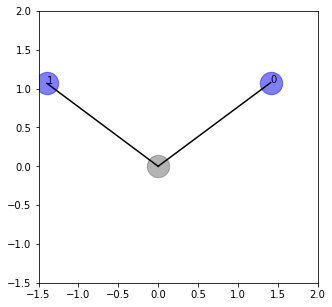

====12th kernel info====
12th-p_support:
torch.Size([2, 2])


12th-x_support:
tensor([[ 2.0161e+00,  1.1508e+00,  1.1497e+00,  1.1494e+00,  1.1493e+00,
          1.0072e+00,  1.2634e+00,  9.5708e-01,  8.9308e-01,  9.2521e-01,
          9.2867e-01,  9.4693e-01,  9.2806e-01,  9.2715e-01,  9.1159e-01,
          9.1368e-01,  9.5663e-01,  9.5556e-01,  9.1172e-01,  9.1783e-01,
          9.3828e-01,  9.1510e-01,  6.0981e-01,  4.0263e-01,  1.0618e+00,
          2.9124e-01,  3.5505e-01,  3.2573e-01,  5.0414e-01,  3.0230e-01,
          3.0426e-01,  3.0700e-01,  3.0455e-01,  3.0589e-01,  3.0211e-01,
          3.0554e-01,  3.0659e-01,  3.0619e-01,  3.0699e-01,  3.0719e-01,
          3.0608e-01,  3.0697e-01,  3.0626e-01,  3.0501e-01, -7.2343e-03,
         -9.9750e-04, -7.5506e-03, -9.0190e-03, -2.8581e-03, -2.9295e-03,
         -2.4029e-03, -2.3914e-03, -1.8847e-03, -8.7065e-04, -4.2039e-03,
         -7.7757e-03, -4.9718e-03, -3.4227e-04, -6.9658e-03, -6.9048e-03,
         -6.7861e-03, -6.9960e-03,

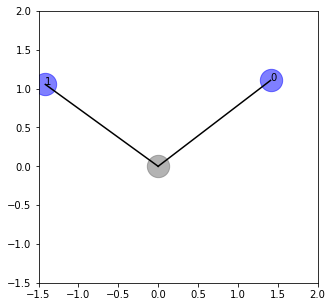

====13th kernel info====
13th-p_support:
torch.Size([2, 2])


13th-x_support:
tensor([[ 2.0034e+00,  1.1428e+00,  1.1417e+00,  1.1413e+00,  1.1412e+00,
          9.9874e-01,  1.2566e+00,  9.5101e-01,  8.8727e-01,  9.1933e-01,
          9.2291e-01,  9.4096e-01,  9.2231e-01,  9.2142e-01,  9.0613e-01,
          9.0845e-01,  9.5046e-01,  9.4938e-01,  9.0612e-01,  9.1231e-01,
          9.3239e-01,  9.0938e-01,  6.0993e-01,  4.0443e-01,  1.0625e+00,
          2.9491e-01,  3.5572e-01,  3.2620e-01,  5.0252e-01,  3.0564e-01,
          3.0765e-01,  3.1037e-01,  3.0794e-01,  3.0934e-01,  3.0579e-01,
          3.0910e-01,  3.1009e-01,  3.0956e-01,  3.1023e-01,  3.1063e-01,
          3.0967e-01,  3.1060e-01,  3.0970e-01,  3.0858e-01,  6.9902e-03,
          2.2556e-04,  4.2536e-03,  2.3770e-03,  6.5152e-03,  6.6359e-03,
          6.5319e-03,  6.5346e-03,  1.7207e-03,  1.9522e-03,  2.0490e-03,
          3.9653e-03,  7.8600e-03,  4.6653e-03,  4.1744e-03,  4.4436e-03,
          4.5633e-03,  4.7957e-03,

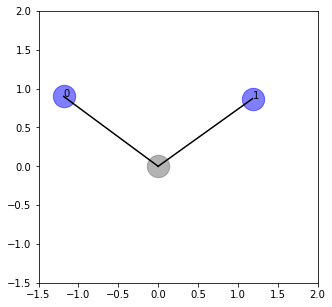

====14th kernel info====
14th-p_support:
torch.Size([2, 2])


14th-x_support:
tensor([[ 1.9792e+00,  1.1314e+00,  1.1292e+00,  1.1286e+00,  1.1286e+00,
          1.0004e+00,  1.2375e+00,  9.5993e-01,  9.2719e-01,  9.2661e-01,
          9.3160e-01,  9.4303e-01,  9.3561e-01,  9.2882e-01,  9.1572e-01,
          9.0699e-01,  9.5794e-01,  9.5390e-01,  9.1605e-01,  9.0970e-01,
          9.3959e-01,  9.1422e-01,  6.0755e-01,  4.2183e-01,  1.0374e+00,
          2.9885e-01,  3.6569e-01,  3.2499e-01,  5.3637e-01,  3.0724e-01,
          3.0655e-01,  3.0934e-01,  3.1001e-01,  3.1092e-01,  3.0487e-01,
          3.1010e-01,  3.0708e-01,  3.0889e-01,  3.1113e-01,  3.0966e-01,
          3.0927e-01,  3.0851e-01,  3.1047e-01,  3.0818e-01,  1.1152e-02,
          1.2707e-03,  2.3101e-03,  2.4326e-02,  7.6470e-03,  3.0891e-02,
          9.6850e-03,  1.0059e-02,  7.2388e-04,  6.2296e-03,  2.2672e-02,
          9.3896e-03,  2.1990e-02,  1.9990e-02,  8.4764e-03,  4.3716e-03,
         -3.5124e-04,  1.1244e-04,

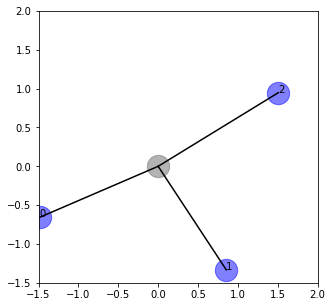

====0th kernel info====
0th-p_support:
torch.Size([3, 2])


0th-x_support:
tensor([[-5.2126e-03, -8.4902e-03, -7.5806e-03, -8.0033e-03, -8.0770e-03,
         -7.6897e-03, -4.1557e-03, -6.0432e-03, -6.2442e-03, -6.0294e-03,
         -6.0557e-03, -6.0913e-03, -6.0525e-03, -6.0831e-03, -5.9936e-03,
         -6.0260e-03, -6.0070e-03, -6.0738e-03, -5.9980e-03, -6.0400e-03,
         -6.0482e-03, -6.0157e-03, -8.0879e-04, -9.8854e-04,  2.1774e-04,
         -2.6822e-03, -8.6625e-04, -2.6662e-03, -5.1099e-04, -4.6716e-03,
         -3.9623e-03, -4.2373e-03, -4.2395e-03, -3.9667e-03, -4.9119e-03,
         -4.4185e-03, -4.2249e-03, -2.2607e-03, -4.4819e-03, -4.6982e-03,
         -3.9457e-03, -3.0206e-03, -4.1077e-03, -4.6974e-03,  5.0581e-01,
          2.8531e-01,  4.3202e-01,  4.6631e-01,  3.9219e-01,  3.8716e-01,
          3.8619e-01,  3.8638e-01,  4.6794e-01,  4.8742e-01,  3.2824e-01,
          4.2745e-01,  4.2999e-01,  3.4263e-01,  4.8880e-01,  4.9468e-01,
          4.9195e-01,  4.9766e-01,  4

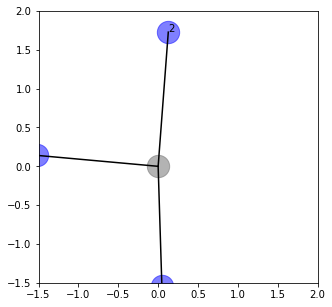

====1th kernel info====
1th-p_support:
torch.Size([3, 2])


1th-x_support:
tensor([[ 1.9972e+00,  1.1349e+00,  1.1340e+00,  1.1335e+00,  1.1335e+00,
          9.9109e-01,  1.2438e+00,  9.5030e-01,  8.7087e-01,  9.2922e-01,
          9.2472e-01,  9.5706e-01,  9.3364e-01,  9.3932e-01,  9.2629e-01,
          9.2403e-01,  9.5052e-01,  9.5068e-01,  9.0497e-01,  9.0342e-01,
          9.4252e-01,  9.2344e-01, -1.1433e-03, -1.0053e-03, -2.2866e-03,
         -8.7151e-04, -8.8472e-04, -1.4710e-03, -2.9589e-03, -7.5068e-04,
         -7.5809e-04, -7.5707e-04, -7.4836e-04, -6.5468e-04, -7.4526e-04,
         -7.4038e-04, -7.5005e-04, -7.5034e-04, -7.4154e-04, -7.5914e-04,
         -7.5254e-04, -7.3128e-04, -7.4917e-04, -7.5535e-04,  5.0885e-01,
          2.8028e-01,  4.1452e-01,  4.4571e-01,  3.8160e-01,  3.7702e-01,
          3.7643e-01,  3.7645e-01,  4.8098e-01,  4.9423e-01,  3.2132e-01,
          4.0948e-01,  4.1116e-01,  3.4108e-01,  4.7732e-01,  4.8360e-01,
          4.8021e-01,  4.8669e-01,  4

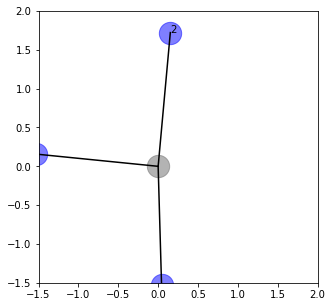

====2th kernel info====
2th-p_support:
torch.Size([3, 2])


2th-x_support:
tensor([[ 1.9988e+00,  1.1475e+00,  1.1342e+00,  1.1337e+00,  1.1337e+00,
          9.9157e-01,  1.2436e+00,  9.4978e-01,  8.7557e-01,  9.2681e-01,
          9.2352e-01,  9.5392e-01,  9.2705e-01,  9.3581e-01,  9.2425e-01,
          9.1637e-01,  9.5004e-01,  9.5003e-01,  9.0376e-01,  9.0520e-01,
          9.4104e-01,  9.1914e-01,  4.3338e-03, -1.1675e-03, -2.4240e-03,
         -6.7508e-04, -1.0997e-03, -8.8803e-04, -2.3908e-03, -8.0864e-04,
         -8.1483e-04, -8.1757e-04, -8.4653e-04, -1.0128e-03, -1.5075e-04,
         -8.0921e-04, -8.2088e-04, -8.1160e-04, -8.2167e-04, -7.6831e-04,
         -8.3380e-04, -6.0424e-04, -8.4598e-04, -8.1372e-04,  5.0769e-01,
          2.8933e-01,  4.2724e-01,  4.6070e-01,  3.8994e-01,  3.8484e-01,
          3.8422e-01,  3.8421e-01,  4.6892e-01,  4.8588e-01,  3.2673e-01,
          4.2238e-01,  4.2420e-01,  3.3969e-01,  4.8490e-01,  4.9102e-01,
          4.8807e-01,  4.9392e-01,  4

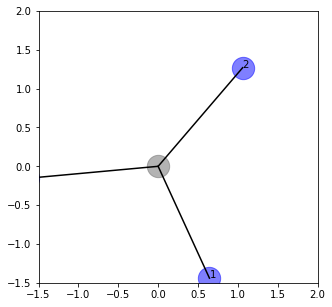

====3th kernel info====
3th-p_support:
torch.Size([3, 2])


3th-x_support:
tensor([[-3.2017e-02, -3.2609e-02, -3.2560e-02, -3.2334e-02, -3.2255e-02,
         -3.5810e-02, -2.9036e-02, -2.6932e-02, -2.6783e-02, -2.6399e-02,
         -2.6356e-02, -2.6637e-02, -2.6420e-02, -2.6204e-02, -2.6211e-02,
         -2.6322e-02, -2.6925e-02, -2.6774e-02, -2.6091e-02, -2.6598e-02,
         -2.6574e-02, -2.6053e-02,  1.4998e-03,  4.5649e-03,  5.5301e-03,
          1.0458e-02,  3.0783e-03,  4.9947e-03,  2.9006e-03,  1.6633e-03,
          1.3692e-03,  1.2655e-03,  1.5165e-03,  1.6373e-03,  1.9534e-03,
          1.7014e-03,  1.4928e-03,  2.3428e-03,  1.2757e-03,  1.5455e-03,
          1.2126e-03,  2.7958e-03,  1.7613e-03,  2.2220e-03,  1.7014e+00,
          7.2355e-01,  1.2380e+00,  9.9091e-01,  8.0551e-01,  7.8854e-01,
          7.8801e-01,  7.8140e-01,  7.3148e-01,  7.5028e-01,  7.3420e-01,
          1.2214e+00,  1.0773e+00,  6.7125e-01,  1.2325e+00,  1.2643e+00,
          1.2645e+00,  1.2666e+00,  1

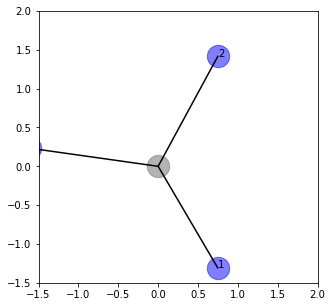

====4th kernel info====
4th-p_support:
torch.Size([3, 2])


4th-x_support:
tensor([[ 8.9325e-01,  5.6765e-01,  5.3186e-01,  5.4573e-01,  5.4579e-01,
          4.8558e-01,  5.6747e-01,  4.3325e-01,  3.8048e-01,  4.2089e-01,
          4.2134e-01,  4.3079e-01,  4.2099e-01,  4.2142e-01,  4.1428e-01,
          4.1449e-01,  4.3352e-01,  4.3411e-01,  4.1461e-01,  4.1590e-01,
          4.2694e-01,  4.1636e-01, -2.9234e-04, -3.5311e-03,  5.7996e-03,
         -6.4901e-03, -4.1702e-03, -5.0522e-03,  1.0941e-03, -6.3170e-03,
         -6.2009e-03, -6.1005e-03, -6.0581e-03, -6.1095e-03, -6.1511e-03,
         -6.1718e-03, -6.1498e-03, -6.1391e-03, -6.1054e-03, -6.1741e-03,
         -6.1616e-03, -6.1580e-03, -5.9802e-03, -6.1225e-03,  9.2866e-01,
          5.5483e-01,  7.4313e-01,  7.6758e-01,  7.4627e-01,  7.4413e-01,
          7.4300e-01,  7.4287e-01,  5.6444e-01,  5.5476e-01,  5.3350e-01,
          7.3706e-01,  7.3688e-01,  5.2761e-01,  7.9347e-01,  7.9924e-01,
          7.9586e-01,  8.0665e-01,  8

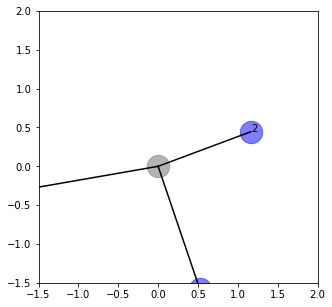

====5th kernel info====
5th-p_support:
torch.Size([3, 2])


5th-x_support:
tensor([[ 0.6739,  0.4838,  0.5024,  0.4893,  0.4894,  0.3785,  0.9873,  0.5824,
          0.5985,  0.5853,  0.5867,  0.5225,  0.5602,  0.5166,  0.5446,  0.5591,
          0.5934,  0.5899,  0.5615,  0.5255,  0.6157,  0.5040,  0.2511,  0.2773,
          0.2166,  0.1813,  0.1385,  0.2796,  0.2304,  0.1258,  0.1135,  0.1059,
          0.1078,  0.1056,  0.1150,  0.1065,  0.1082,  0.1104,  0.1051,  0.1053,
          0.1042,  0.1061,  0.1057,  0.1081,  0.5250,  0.4929,  0.6278,  0.6470,
          0.6078,  0.6039,  0.6010,  0.6002,  0.4849,  0.4018,  0.5107,  0.6216,
          0.6201,  0.5609,  0.7069,  0.7166,  0.7239,  0.7276,  0.7137,  0.7276,
          0.7106,  0.7164,  0.7297,  0.7220,  0.6909,  0.7216,  0.7172,  0.7148,
          0.7028,  0.5860,  0.6684,  0.5729,  0.6021,  0.1701,  0.4073,  0.3700,
          0.3540,  0.3299,  0.4139,  0.4246,  0.3636,  0.5099,  0.3531,  0.4027,
          0.4053,  0.4379,  0.3363

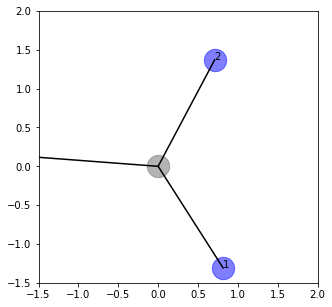

====6th kernel info====
6th-p_support:
torch.Size([3, 2])


6th-x_support:
tensor([[ 9.5866e-01,  6.0544e-01,  5.6672e-01,  5.7197e-01,  5.7196e-01,
          5.0751e-01,  6.0159e-01,  4.5445e-01,  4.1063e-01,  4.4067e-01,
          4.4166e-01,  4.5039e-01,  4.4163e-01,  4.4123e-01,  4.3493e-01,
          4.3577e-01,  4.5453e-01,  4.5458e-01,  4.3476e-01,  4.3796e-01,
          4.4661e-01,  4.3542e-01,  5.5564e-03,  1.0084e-02,  1.4175e-02,
          1.0215e-02,  1.3276e-02,  1.0018e-03,  1.2757e-02,  1.1939e-02,
          1.1294e-02,  1.2065e-02,  1.1662e-02,  1.0545e-02,  1.0331e-02,
          9.1869e-03,  1.0217e-02,  1.1732e-02,  1.1486e-02,  1.1945e-02,
          1.1944e-02,  1.1802e-02,  1.2006e-02,  1.1599e-02,  7.8197e-01,
          6.1195e-01,  7.3767e-01,  7.4495e-01,  7.2737e-01,  7.2444e-01,
          7.2357e-01,  7.2506e-01,  5.8562e-01,  5.4147e-01,  5.1005e-01,
          7.3405e-01,  7.2328e-01,  5.5075e-01,  7.7634e-01,  7.7776e-01,
          7.7677e-01,  7.7954e-01,  7

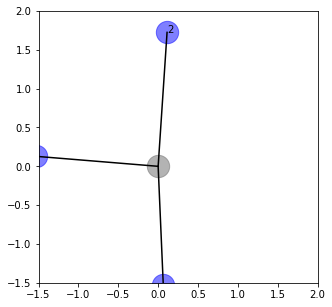

====7th kernel info====
7th-p_support:
torch.Size([3, 2])


7th-x_support:
tensor([[ 1.9992e+00,  1.1381e+00,  1.1334e+00,  1.1329e+00,  1.1329e+00,
          1.0035e+00,  1.2429e+00,  9.4981e-01,  8.7403e-01,  9.2547e-01,
          9.2234e-01,  9.5430e-01,  9.2907e-01,  9.3664e-01,  9.2743e-01,
          9.1747e-01,  9.5008e-01,  9.4950e-01,  9.0353e-01,  9.0480e-01,
          9.4026e-01,  9.2262e-01, -1.1765e-03, -1.0418e-03, -2.0108e-03,
         -8.6372e-04, -9.8443e-04, -1.4918e-03, -2.6444e-03, -8.0194e-04,
         -7.7721e-04, -8.4225e-04, -8.0743e-04, -8.6429e-04, -8.2683e-04,
         -9.0517e-04, -7.9772e-04, -7.6717e-04, -7.7549e-04, -9.1019e-04,
         -7.8190e-04, -7.7992e-04, -1.0008e-03, -7.7030e-04,  5.0812e-01,
          2.8390e-01,  4.1907e-01,  4.5146e-01,  3.8492e-01,  3.8017e-01,
          3.7956e-01,  3.7957e-01,  4.7605e-01,  4.9170e-01,  3.2387e-01,
          4.1408e-01,  4.1581e-01,  3.4008e-01,  4.8010e-01,  4.8638e-01,
          4.8316e-01,  4.8934e-01,  4

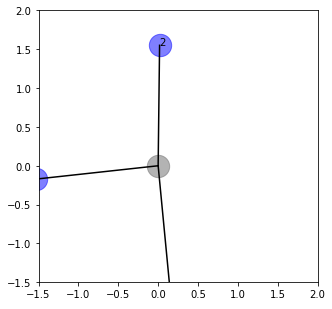

====8th kernel info====
8th-p_support:
torch.Size([3, 2])


8th-x_support:
tensor([[ 2.0007e+00,  1.1361e+00,  1.1324e+00,  1.1319e+00,  1.1319e+00,
          9.8990e-01,  1.2423e+00,  9.5044e-01,  8.7351e-01,  9.2276e-01,
          9.2043e-01,  9.5358e-01,  9.3120e-01,  9.3546e-01,  9.3185e-01,
          9.1727e-01,  9.5071e-01,  9.4899e-01,  9.0324e-01,  9.0413e-01,
          9.3776e-01,  9.2728e-01, -1.3223e-03, -1.1320e-03, -2.1311e-03,
         -9.8617e-04, -1.2118e-03, -1.7248e-03, -2.7729e-03, -1.0005e-03,
         -1.1305e-03, -9.1523e-04, -9.2036e-04, -9.2978e-04, -8.0545e-04,
         -1.0543e-03, -9.5703e-04, -8.1502e-04, -8.8115e-04, -9.1531e-04,
         -8.1509e-04, -9.9030e-04, -8.9969e-04, -9.0007e-04,  5.0983e-01,
          2.7448e-01,  4.0504e-01,  4.3538e-01,  3.7596e-01,  3.7178e-01,
          3.7122e-01,  3.7125e-01,  4.8880e-01,  5.0103e-01,  3.1857e-01,
          3.9985e-01,  4.0145e-01,  3.4242e-01,  4.7167e-01,  4.7819e-01,
          4.7449e-01,  4.8131e-01,  4

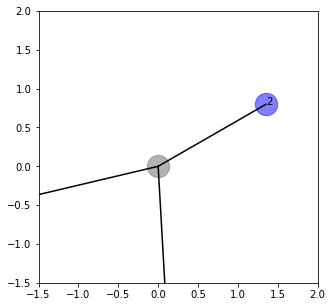

====9th kernel info====
9th-p_support:
torch.Size([3, 2])


9th-x_support:
tensor([[-8.9307e-03, -8.5195e-03, -9.5137e-03, -9.0549e-03, -9.0518e-03,
          4.2749e-03, -8.4073e-03, -8.4850e-03, -8.5421e-03, -8.4218e-03,
         -8.4145e-03, -8.5181e-03, -8.4092e-03, -8.4320e-03, -8.3438e-03,
         -8.3318e-03, -8.4834e-03, -8.5109e-03, -8.3527e-03, -8.3477e-03,
         -8.4686e-03, -8.3893e-03, -4.2413e-04, -7.8079e-04, -7.0095e-04,
         -3.6429e-04, -7.1978e-04, -3.4057e-04, -7.2680e-04, -6.6247e-04,
         -8.7414e-04, -8.2259e-04, -5.4652e-04, -7.8863e-04, -7.6759e-04,
         -6.1939e-04, -8.1003e-04, -8.7268e-04, -6.8102e-04, -6.6430e-04,
         -6.2397e-04, -8.4769e-04, -6.7914e-04, -8.3203e-04,  1.1471e+00,
          8.9644e-01,  9.4067e-01,  9.0634e-01,  9.3420e-01,  9.3346e-01,
          9.3255e-01,  9.3017e-01,  1.1766e+00,  9.1540e-01,  6.0998e-01,
          9.3226e-01,  9.2935e-01,  8.8725e-01,  9.8838e-01,  9.5250e-01,
          9.2923e-01,  9.9920e-01,  9

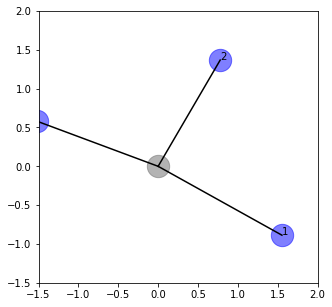

====10th kernel info====
10th-p_support:
torch.Size([3, 2])


10th-x_support:
tensor([[-5.3923e-03, -9.4950e-03, -9.0541e-03, -9.4765e-03, -9.4785e-03,
         -5.8291e-03, -5.4670e-03, -8.1076e-03, -8.3302e-03, -8.1075e-03,
         -8.1521e-03, -8.1546e-03, -8.1013e-03, -8.1504e-03, -8.0896e-03,
         -8.1223e-03, -8.0846e-03, -8.1504e-03, -8.0957e-03, -8.0910e-03,
         -8.1173e-03, -8.1141e-03, -1.6608e-03, -1.1240e-03, -2.0670e-04,
          2.0290e-03, -1.6318e-03, -1.1378e-03,  9.0846e-05, -4.0365e-03,
         -3.3532e-03, -3.6656e-03, -3.8067e-03, -3.4122e-03, -4.6572e-03,
         -3.3860e-03, -3.1837e-03, -9.1278e-04, -3.6464e-03, -3.2846e-03,
         -3.5110e-03, -2.6317e-03, -3.5910e-03, -3.9928e-03,  5.0589e-01,
          2.8111e-01,  4.2782e-01,  4.6105e-01,  3.8884e-01,  3.8386e-01,
          3.8295e-01,  3.8315e-01,  4.7157e-01,  4.8849e-01,  3.2605e-01,
          4.2323e-01,  4.2564e-01,  3.4216e-01,  4.8585e-01,  4.9169e-01,
          4.8888e-01,  4.9477e-01,

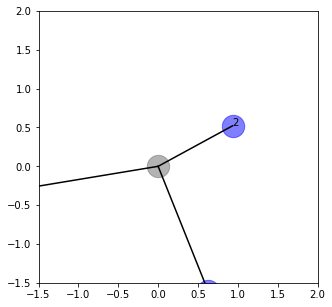

====11th kernel info====
11th-p_support:
torch.Size([3, 2])


11th-x_support:
tensor([[ 6.4922e-01,  4.0085e-01,  4.0024e-01,  3.9960e-01,  3.9981e-01,
          3.5580e-01,  1.0090e+00,  4.6022e-01,  4.2135e-01,  4.4635e-01,
          4.4426e-01,  4.5865e-01,  4.5117e-01,  4.4224e-01,  4.4882e-01,
          4.4694e-01,  4.5859e-01,  4.5968e-01,  4.4509e-01,  4.4012e-01,
          4.4923e-01,  4.4499e-01, -9.1251e-03, -7.6348e-03, -9.4891e-03,
         -8.0579e-03, -5.9625e-03, -9.0278e-03, -1.0056e-02, -5.6224e-03,
         -5.5787e-03, -4.9539e-03, -5.2785e-03, -5.2234e-03, -5.6657e-03,
         -4.9239e-03, -4.9389e-03, -5.3691e-03, -5.0136e-03, -4.7563e-03,
         -4.9469e-03, -4.5207e-03, -5.1606e-03, -5.1399e-03,  5.3509e-01,
          3.4742e-01,  5.5537e-01,  6.0853e-01,  4.4018e-01,  4.2769e-01,
          4.2728e-01,  4.2680e-01,  3.4111e-01,  3.5303e-01,  3.7081e-01,
          5.5397e-01,  5.5299e-01,  3.1898e-01,  5.4679e-01,  5.4317e-01,
          5.4852e-01,  5.4991e-01,

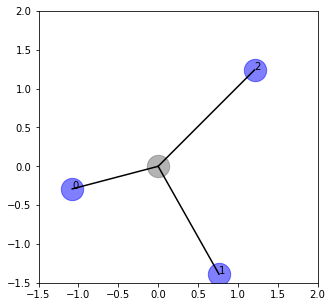

====12th kernel info====
12th-p_support:
torch.Size([3, 2])


12th-x_support:
tensor([[-3.8222e-04, -1.6723e-03, -1.0631e-03, -2.1254e-03, -2.3048e-03,
         -1.6281e-05,  5.5122e-04, -4.0638e-03, -3.9325e-03, -4.2072e-03,
         -3.9793e-03,  1.3409e-02, -4.1522e-03, -4.4087e-03, -3.9377e-03,
         -4.1144e-03, -4.2571e-03, -4.0536e-03, -4.3423e-03, -4.1645e-03,
         -4.3840e-03, -2.7121e-03, -6.2445e-04, -1.6204e-03,  7.8037e-04,
          1.1857e-03,  1.9334e-05, -9.0307e-04, -2.3039e-03, -6.7120e-04,
         -7.2631e-04, -6.9169e-04, -4.5355e-04, -6.9190e-04, -7.1647e-04,
         -7.8266e-04, -5.2437e-04, -6.4014e-04, -4.4288e-04, -8.0657e-04,
         -4.4545e-04, -8.2387e-04, -6.5505e-04, -7.3708e-04,  4.7834e-01,
          3.6684e-01,  5.7452e-01,  6.2528e-01,  4.5755e-01,  4.5072e-01,
          4.4845e-01,  4.3977e-01,  3.5504e-01,  4.0598e-01,  4.0186e-01,
          5.7534e-01,  5.6687e-01,  3.3352e-01,  5.7916e-01,  5.7490e-01,
          5.6734e-01,  5.5844e-01,

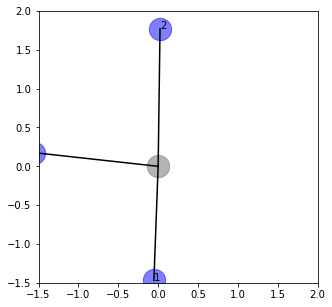

====13th kernel info====
13th-p_support:
torch.Size([3, 2])


13th-x_support:
tensor([[ 1.8069e+00,  1.3404e+00,  1.0495e+00,  1.0263e+00,  1.0273e+00,
          8.2965e-01,  9.7263e-01,  8.8971e-01,  8.7627e-01,  8.3976e-01,
          8.5900e-01,  8.5626e-01,  8.4356e-01,  8.4510e-01,  8.3396e-01,
          8.5790e-01,  8.8504e-01,  8.7216e-01,  8.5436e-01,  8.9528e-01,
          8.6916e-01,  8.3671e-01, -1.0936e-02, -2.9736e-03, -6.2409e-03,
         -7.4092e-04,  9.4072e-04, -7.6287e-03, -3.0823e-03,  9.5265e-04,
         -6.2114e-04, -4.9361e-03,  6.4064e-04, -2.0542e-04,  1.1253e-03,
         -4.3891e-03,  9.3245e-04,  7.3964e-04,  1.2119e-04, -5.1377e-03,
         -6.1207e-05,  4.8561e-04, -5.5999e-03,  1.1444e-03,  5.3654e-01,
          3.3766e-01,  5.4357e-01,  5.8252e-01,  5.6295e-01,  5.5528e-01,
          5.5121e-01,  5.5001e-01,  2.6321e-01,  2.9553e-01,  2.2859e-01,
          5.3887e-01,  5.4678e-01,  2.3439e-01,  6.2497e-01,  6.2617e-01,
          6.2507e-01,  6.3344e-01,

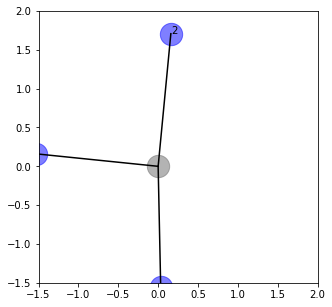

====14th kernel info====
14th-p_support:
torch.Size([3, 2])


14th-x_support:
tensor([[ 1.9994e+00,  1.1349e+00,  1.1341e+00,  1.1336e+00,  1.1336e+00,
          1.0022e+00,  1.2435e+00,  9.5085e-01,  8.7370e-01,  9.2939e-01,
          9.2468e-01,  9.5736e-01,  9.2741e-01,  9.3986e-01,  9.2874e-01,
          9.1941e-01,  9.5110e-01,  9.5112e-01,  9.0488e-01,  9.0362e-01,
          9.4413e-01,  9.2473e-01, -4.9644e-04, -1.8304e-03, -1.6200e-03,
         -6.7515e-04, -1.1229e-03, -1.9965e-03, -2.7197e-03, -6.8267e-04,
         -6.7917e-04, -5.4551e-04, -5.3528e-04, -8.8419e-04, -9.5698e-04,
         -9.7357e-04, -1.0799e-03, -5.4242e-04, -1.3181e-03, -7.9906e-04,
         -1.0051e-03, -5.4282e-04, -5.2815e-04, -6.4848e-04,  5.0849e-01,
          2.7910e-01,  4.1233e-01,  4.4364e-01,  3.7958e-01,  3.7508e-01,
          3.7451e-01,  3.7453e-01,  4.8307e-01,  4.9625e-01,  3.2075e-01,
          4.0729e-01,  4.0898e-01,  3.4225e-01,  4.7528e-01,  4.8160e-01,
          4.7814e-01,  4.8478e-01,

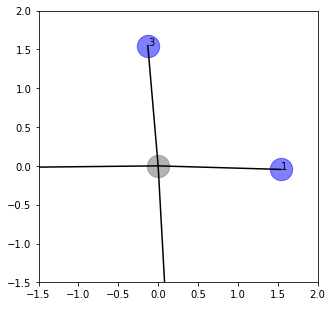

====0th kernel info====
0th-p_support:
torch.Size([4, 2])


0th-x_support:
tensor([[-4.0241e-02, -1.1476e-03, -2.6137e-02,  2.2045e-03, -4.0869e-02,
         -1.8761e-03, -7.8408e-03,  1.9307e-03, -4.3245e-02, -3.4050e-02,
         -7.8829e-04,  2.1614e-03, -5.0544e-03,  2.5886e-03,  2.7552e-04,
          1.5675e-03,  6.7866e-04,  1.4875e-03, -6.1906e-04,  1.0201e-03,
         -6.5918e-03, -9.3587e-04,  7.4577e-05,  4.6158e-04,  1.0135e-03,
          1.7954e-03, -5.2212e-04, -1.5908e-02,  7.2873e-04,  6.1122e-05,
          2.1969e-04, -4.3336e-04,  4.8292e-03,  2.9525e-03,  1.9460e-04,
         -4.1746e-04,  5.8151e-05,  5.2168e-03, -1.8396e-02,  8.4738e-03,
         -2.2074e-04,  3.9471e-04,  5.8271e-04, -4.3317e-04,  3.3843e-04,
         -7.2128e-03, -1.4672e-04, -8.1942e-05, -1.8655e-04,  5.5972e-05,
         -1.2090e-02, -6.3066e-03,  1.0973e-04,  1.0074e-05, -1.3535e-02,
          2.0427e-04, -6.1898e-07, -9.8269e-04,  5.0340e-04, -6.9489e-03,
          1.0961e-03,  1.1805e-04,  2

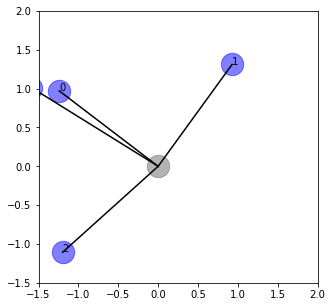

====1th kernel info====
1th-p_support:
torch.Size([4, 2])


1th-x_support:
tensor([[ 1.8935e+00,  9.9236e-01,  9.8814e-01,  9.9088e-01,  9.9302e-01,
          8.4939e-01,  1.1551e+00,  9.8379e-01,  8.8245e-01,  9.2003e-01,
          9.4546e-01,  9.5786e-01,  9.1680e-01,  9.5098e-01,  8.6813e-01,
          9.0616e-01,  9.8067e-01,  9.6446e-01,  8.8918e-01,  9.2188e-01,
          9.2744e-01,  9.2541e-01,  1.1422e-05,  3.0400e-04, -5.3618e-04,
          1.3576e-01,  2.5110e-03,  9.3551e-04,  2.0345e-02,  2.1301e-03,
          1.8883e-03,  2.0676e-03, -5.8353e-04,  1.9999e-03,  1.5351e-04,
          2.0072e-03,  2.2803e-03, -1.7376e-04,  1.7501e-03, -8.0366e-04,
          2.0551e-03,  9.5519e-05,  3.5482e-04,  1.5842e-03,  3.8825e-01,
          1.0120e+00,  3.7104e-01,  3.7939e-01,  3.6902e-01,  3.7117e-01,
          3.6892e-01,  3.6790e-01,  4.6392e-01,  3.4431e-01,  2.5193e-01,
          3.6927e-01,  3.6330e-01,  5.1214e-01,  3.4166e-01,  3.5012e-01,
          3.5813e-01,  3.5204e-01,  3

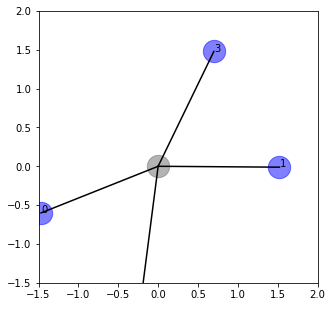

====2th kernel info====
2th-p_support:
torch.Size([4, 2])


2th-x_support:
tensor([[ 2.0071e+00,  1.1448e+00,  1.1435e+00,  1.1430e+00,  1.1430e+00,
          1.0033e+00,  1.2527e+00,  9.6410e-01,  8.9633e-01,  9.3276e-01,
          9.3441e-01,  9.5566e-01,  9.3323e-01,  9.3244e-01,  9.1901e-01,
          9.2185e-01,  9.6422e-01,  9.6450e-01,  9.2062e-01,  9.2822e-01,
          9.4662e-01,  9.1997e-01, -1.9791e-03, -9.0644e-04, -4.9979e-03,
         -1.5213e-03, -1.0739e-03, -3.0208e-04, -1.2357e-03, -1.2809e-03,
         -1.2933e-03, -1.3837e-03, -1.2917e-03, -1.3001e-03, -9.1367e-04,
         -1.2918e-03, -1.2925e-03, -1.2977e-03, -1.2983e-03, -1.2960e-03,
         -1.2982e-03, -1.3910e-03, -1.2973e-03, -1.2933e-03,  2.6188e-03,
          1.5252e-03,  2.1316e-03,  2.1720e-03,  1.6807e-03,  1.6319e-03,
          1.6246e-03,  1.6267e-03, -2.3814e-04,  8.3940e-05,  1.2815e-03,
          2.0759e-03,  2.1170e-03, -7.1599e-05,  2.0239e-03,  2.0451e-03,
          2.0351e-03,  2.0548e-03,  2

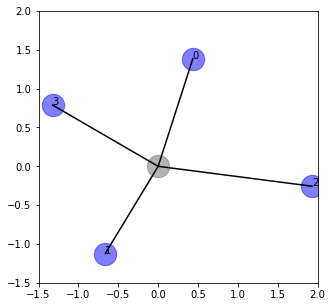

====3th kernel info====
3th-p_support:
torch.Size([4, 2])


3th-x_support:
tensor([[ 2.0890e+00,  1.2067e+00,  1.2063e+00,  1.2061e+00,  1.2060e+00,
          1.0170e+00,  1.2782e+00,  1.0190e+00,  9.5040e-01,  9.8399e-01,
          9.8602e-01,  1.0051e+00,  9.9739e-01,  9.7452e-01,  9.9408e-01,
          9.8779e-01,  1.0146e+00,  1.0103e+00,  9.8421e-01,  9.8470e-01,
          9.9693e-01,  9.7829e-01,  8.2550e-03,  2.2223e-03,  8.9668e-03,
          5.7906e-03,  2.7492e-02,  3.0317e-02,  1.1516e-02,  2.8641e-02,
          2.7776e-02,  2.1172e-02,  2.8547e-02,  2.8901e-02,  1.0003e-02,
          2.9573e-02,  2.8858e-02,  2.7983e-02,  2.9910e-02,  3.3035e-02,
          2.1279e-02,  2.7828e-02,  2.8173e-02,  4.1147e-03,  5.2871e-02,
          5.6053e-02,  1.3070e-02,  9.5751e-03,  1.1798e-02,  1.1745e-02,
          1.2200e-02,  1.2277e-02, -1.3181e-03,  4.8944e-04,  4.2139e-03,
          8.5186e-03,  3.4900e-02,  1.0599e-02,  3.0295e-02,  3.0021e-02,
          3.3631e-02,  3.2539e-02,  3

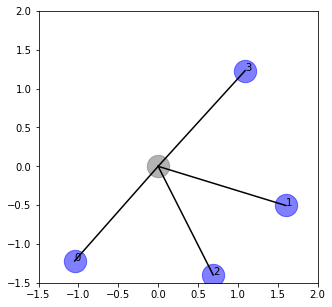

====4th kernel info====
4th-p_support:
torch.Size([4, 2])


4th-x_support:
tensor([[ 1.9982e+00,  1.1418e+00,  1.1405e+00,  1.1401e+00,  1.1401e+00,
          1.0010e+00,  1.2551e+00,  9.4729e-01,  8.7679e-01,  9.1754e-01,
          9.1917e-01,  9.3891e-01,  9.1745e-01,  9.1838e-01,  9.0310e-01,
          9.0534e-01,  9.4755e-01,  9.4832e-01,  9.0502e-01,  9.1109e-01,
          9.3129e-01,  9.0483e-01,  2.8936e-04,  1.1539e-04,  9.4938e-05,
         -1.4125e-05, -2.8672e-05,  9.6532e-06,  2.7469e-05,  1.9609e-05,
          1.1456e-04,  2.0265e-05,  1.7193e-05, -5.9947e-05, -1.9543e-05,
          1.7169e-05,  1.9297e-05,  1.7599e-05,  1.9331e-04,  2.0069e-05,
          1.3410e-04,  7.6242e-05,  2.2082e-05, -6.7136e-07,  3.4550e-01,
          3.2161e-01,  3.4993e-01,  3.5130e-01,  3.4931e-01,  3.5235e-01,
          3.4840e-01,  3.4837e-01,  7.4851e-01,  5.0356e-01,  3.2556e-01,
          3.5046e-01,  4.7839e-01,  4.3590e-01,  3.8992e-01,  3.8991e-01,
          3.8857e-01,  3.8822e-01,  3

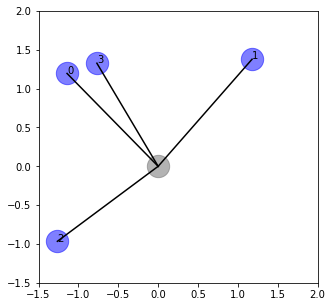

====5th kernel info====
5th-p_support:
torch.Size([4, 2])


5th-x_support:
tensor([[ 2.3129e-02,  5.6199e-03,  2.5110e-03, -4.4240e-03,  2.3779e-02,
          3.4282e-02,  6.7606e-03,  8.7089e-03,  8.4705e-03,  1.3085e-02,
          1.2157e-02,  2.8705e-02,  9.6597e-03,  1.2896e-02,  2.7602e-02,
          1.1639e-02,  8.7897e-03,  8.2245e-03,  1.3398e-02,  2.9176e-02,
          9.0955e-03,  7.6604e-03, -1.0625e-01, -1.2669e-01, -1.7912e-01,
         -1.3265e-01, -1.3054e-01, -1.5656e-01, -8.7972e-02, -4.1553e-02,
         -1.3688e-01, -1.1902e-01, -8.0196e-02, -1.6593e-01, -1.3312e-01,
         -7.4739e-04, -5.1774e-02, -1.2327e-01, -1.5967e-01, -1.3445e-01,
          1.2422e-01, -3.8025e-02, -3.8699e-02, -1.3670e-01,  2.1666e-02,
         -5.1798e-03,  5.8024e-03,  6.3182e-03,  1.2100e-02,  1.1246e-02,
          1.2293e-02,  9.2568e-03,  1.1692e-02,  1.5663e-02,  6.3516e-03,
          7.5112e-03,  4.8252e-03,  1.6508e-02,  1.2454e-02,  1.3702e-02,
          1.2373e-02,  1.2934e-02,  1

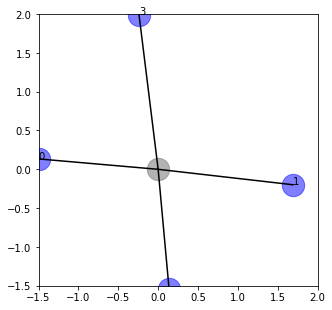

====6th kernel info====
6th-p_support:
torch.Size([4, 2])


6th-x_support:
tensor([[ 2.0084e+00,  1.1627e+00,  1.1601e+00,  1.1602e+00,  1.1601e+00,
          1.0033e+00,  1.2579e+00,  1.0141e+00,  1.0010e+00,  9.7189e-01,
          9.8596e-01,  9.8076e-01,  9.8492e-01,  9.6882e-01,  9.7322e-01,
          1.0021e+00,  1.0115e+00,  1.0032e+00,  9.6870e-01,  1.0065e+00,
          9.8325e-01,  9.5199e-01,  2.2018e-02,  3.4382e-02,  3.3785e-03,
          2.2010e-03,  8.6899e-05,  9.9675e-03,  1.5155e-02, -5.6513e-03,
          2.4319e-03,  1.7722e-04, -4.7882e-03,  3.8961e-02, -2.9697e-02,
         -4.7158e-03,  7.3862e-03,  2.7912e-03, -3.4447e-03,  3.7387e-03,
          3.8513e-04,  2.7111e-04, -4.6106e-03,  2.8594e-02,  2.6167e-02,
          3.0909e-02,  5.2585e-02,  3.6645e-02,  1.4376e-02,  4.0541e-02,
          1.3556e-02,  1.1554e-02,  1.1609e-02,  2.5484e-02, -2.0610e-02,
          4.5849e-02,  3.2698e-02,  1.0187e-02,  3.2802e-02,  3.2112e-02,
          3.7933e-02,  5.2048e-02,  3

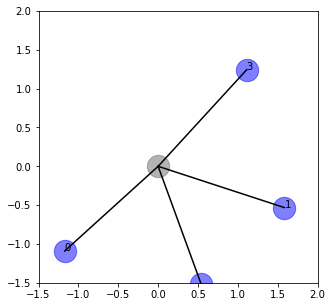

====7th kernel info====
7th-p_support:
torch.Size([4, 2])


7th-x_support:
tensor([[ 1.9983e+00,  1.1412e+00,  1.1404e+00,  1.1399e+00,  1.1400e+00,
          1.0008e+00,  1.2550e+00,  9.4720e-01,  8.7646e-01,  9.1751e-01,
          9.1943e-01,  9.3896e-01,  9.1804e-01,  9.1742e-01,  9.0352e-01,
          9.0640e-01,  9.4746e-01,  9.4832e-01,  9.0511e-01,  9.1164e-01,
          9.3122e-01,  9.0475e-01,  8.4349e-08,  1.7693e-04,  7.1704e-05,
          8.1430e-05,  1.2087e-04, -2.8221e-05,  1.3238e-05,  4.2452e-05,
          2.5622e-05,  9.6882e-05,  3.2429e-04, -1.4412e-03,  5.9397e-06,
          8.5157e-05,  9.1637e-05,  6.2742e-06,  8.5518e-04,  1.0495e-04,
          4.8267e-06, -1.1525e-06,  5.3385e-04,  1.2260e-04,  3.4575e-01,
          3.2134e-01,  3.4981e-01,  3.5119e-01,  3.4926e-01,  3.5229e-01,
          3.4835e-01,  3.4832e-01,  7.4747e-01,  5.0354e-01,  3.2553e-01,
          3.5032e-01,  4.7833e-01,  4.3561e-01,  3.8977e-01,  3.8977e-01,
          3.8842e-01,  3.8811e-01,  3

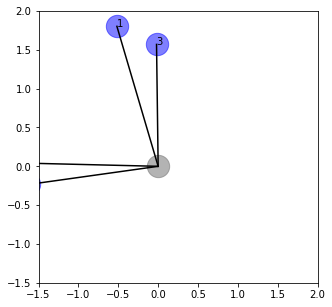

====8th kernel info====
8th-p_support:
torch.Size([4, 2])


8th-x_support:
tensor([[ 1.4949e-02,  1.6905e-02,  1.5715e-02,  1.9492e-02,  1.7359e-02,
          2.8230e-02,  1.1145e-02,  1.7510e-02,  1.4911e-02,  1.2043e-02,
          3.0175e-03,  1.2170e-02,  1.2060e-02,  3.0346e-03,  1.7811e-02,
          1.4251e-02,  1.6022e-02,  1.5084e-02,  1.4852e-02,  1.1980e-02,
         -2.5408e-03,  1.5887e-02,  1.7331e-02,  1.1061e-02,  3.1006e-02,
          6.7644e-03, -4.1937e-03,  1.0239e-02,  1.8878e-02, -8.7015e-03,
         -8.9431e-03,  7.0281e-03,  6.7286e-03, -8.7876e-03,  9.3015e-03,
         -9.0960e-03,  7.5452e-03, -8.4356e-03,  7.3235e-03,  6.8820e-03,
         -7.8745e-03,  7.3142e-03, -8.9423e-03,  6.7556e-03,  1.5370e-02,
          1.6684e-02,  1.6053e-02,  1.0557e-02,  3.9884e-03,  4.6356e-03,
          5.5291e-03,  4.4345e-03, -5.1604e-04,  1.5251e-02, -5.1806e-03,
          1.6036e-02, -6.1301e-03,  8.0110e-03, -4.5791e-03,  6.5255e-03,
         -3.2733e-03,  6.3739e-03,  3

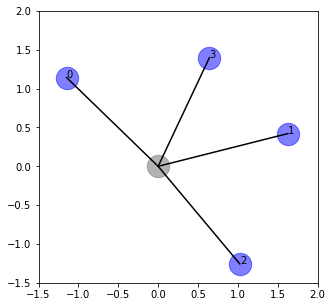

====9th kernel info====
9th-p_support:
torch.Size([4, 2])


9th-x_support:
tensor([[ 1.9964e+00,  1.1412e+00,  1.1399e+00,  1.1394e+00,  1.1394e+00,
          9.9920e-01,  1.2547e+00,  9.4605e-01,  8.7516e-01,  9.1618e-01,
          9.1782e-01,  9.3781e-01,  9.1629e-01,  9.1763e-01,  9.0206e-01,
          9.0418e-01,  9.4632e-01,  9.4723e-01,  9.0428e-01,  9.1033e-01,
          9.3015e-01,  9.0405e-01,  5.6134e-05,  8.5041e-04,  2.2949e-04,
          6.9932e-05,  5.1443e-05,  1.1386e-04,  4.7078e-05,  6.8325e-05,
          5.9347e-05,  2.7670e-05,  6.6771e-05,  7.9960e-05,  3.4669e-05,
          8.2745e-05,  4.7782e-05,  3.6262e-05,  6.9237e-05,  7.3627e-04,
          5.8392e-05,  7.4893e-05,  3.1735e-05,  2.5163e-05,  3.4519e-01,
          3.2012e-01,  3.4958e-01,  3.5094e-01,  3.4902e-01,  3.5211e-01,
          3.4812e-01,  3.4808e-01,  7.4747e-01,  5.0367e-01,  3.2541e-01,
          3.5011e-01,  4.7933e-01,  4.3474e-01,  3.8950e-01,  3.8950e-01,
          3.8818e-01,  3.8781e-01,  3

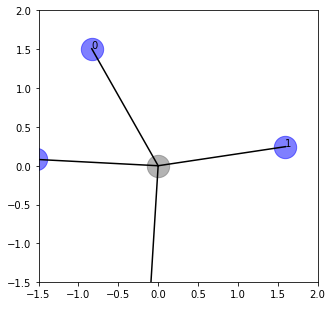

====10th kernel info====
10th-p_support:
torch.Size([4, 2])


10th-x_support:
tensor([[-2.2734e-03, -6.9998e-03, -5.7425e-03, -1.7191e-02, -1.7216e-02,
         -4.0354e-03, -3.4649e-04,  1.9444e-03,  7.5858e-03,  1.8406e-03,
         -6.4838e-04, -1.4739e-02,  3.6451e-03,  5.3321e-03, -1.4197e-02,
          1.6913e-03,  2.9810e-03,  1.0385e-02,  6.5140e-03,  6.4417e-04,
         -1.6935e-02, -1.4953e-02,  4.7313e-03,  7.2683e-03,  1.7270e-02,
          9.4503e-03,  1.2675e-02,  5.8616e-03,  8.8740e-03,  4.0327e-03,
          1.1984e-02,  5.1191e-03,  4.0559e-03,  5.6672e-03,  7.8717e-03,
          1.5803e-03,  5.0763e-03,  4.1369e-03,  4.3298e-03,  4.4698e-03,
          2.1168e-02,  5.2182e-03,  4.1447e-03,  2.6061e-02, -2.2031e-02,
         -1.1835e-02, -2.2281e-02, -2.1711e-02, -1.7937e-02, -1.8688e-02,
         -2.0230e-02, -1.6826e-02,  3.4067e-03, -7.9920e-03, -7.6059e-03,
         -1.9010e-02, -2.2656e-02, -1.5870e-02, -1.0058e-02, -2.0170e-02,
         -1.1141e-02, -2.1543e-02,

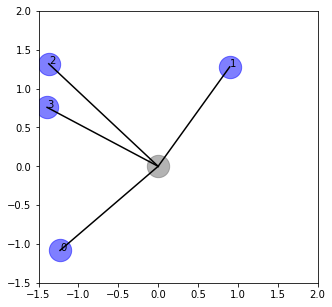

====11th kernel info====
11th-p_support:
torch.Size([4, 2])


11th-x_support:
tensor([[-1.8206e-02, -1.0468e-04, -5.2991e-05,  2.3954e-02, -9.1846e-05,
          1.2626e-02, -9.5235e-03,  3.1133e-03, -1.6024e-02, -1.1110e-02,
          8.6400e-03, -1.3865e-02, -6.0523e-03, -7.3879e-03,  1.0395e-02,
          5.1894e-03, -1.9938e-04,  1.8747e-02, -9.5414e-03, -5.2323e-03,
          4.1768e-04, -1.1431e-02,  4.1995e-04,  1.7435e-02, -1.3682e-03,
          1.2677e-03,  1.6804e-02,  1.0561e-02,  7.4676e-03,  1.8297e-03,
         -1.0584e-03, -1.0344e-03, -1.1154e-03, -2.7987e-04,  8.3775e-03,
         -6.7746e-04, -8.4730e-04,  1.5184e-02,  1.4352e-02, -7.6323e-04,
          1.4153e-02, -8.5069e-04,  1.1261e-02,  1.4733e-02, -2.6835e-03,
          5.3304e-03,  9.8589e-03, -1.2325e-03, -5.4965e-03, -1.9573e-03,
         -6.9693e-03, -2.2076e-03, -5.5223e-03, -4.3636e-03,  1.0151e-02,
         -4.4896e-03, -5.6554e-03,  1.1261e-02, -1.8849e-03, -1.1561e-02,
         -2.9533e-03, -8.9711e-03,

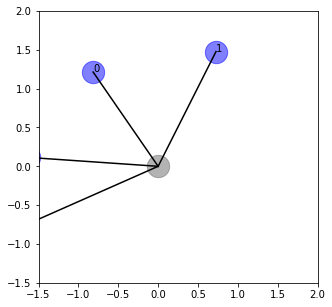

====12th kernel info====
12th-p_support:
torch.Size([4, 2])


12th-x_support:
tensor([[-5.4581e-04, -4.9120e-04, -5.6086e-04, -5.1594e-04, -4.9222e-04,
         -1.1691e-03, -3.9036e-04, -5.2069e-04, -3.2124e-04, -2.2808e-04,
          1.5613e-06, -1.2876e-04, -1.8741e-03, -2.2759e-03,  2.0780e-04,
         -4.4684e-04, -1.6693e-03, -2.7402e-03, -3.4307e-04, -1.2764e-03,
         -4.4006e-04, -3.0423e-04,  4.5230e-04, -2.9341e-04, -1.7196e-03,
          9.0649e-04, -7.6179e-04, -9.2203e-04, -4.2250e-04, -4.9828e-04,
         -5.1867e-04, -5.1024e-04, -5.0479e-04, -5.0038e-04, -4.9101e-04,
         -5.2486e-04, -5.1431e-04, -5.1461e-04, -5.1093e-04, -5.1316e-04,
         -4.9222e-04, -5.0778e-04, -5.2009e-04, -5.1164e-04,  1.9212e-04,
         -2.5197e-04, -5.0554e-06, -1.3492e-03, -4.3846e-05, -8.9895e-04,
         -4.1000e-05, -4.3647e-05,  6.0702e-04, -4.3835e-06, -4.8846e-05,
          4.4755e-05, -9.2168e-06, -3.3531e-04,  2.6638e-04,  1.4368e-03,
          8.6110e-04,  8.8232e-04,

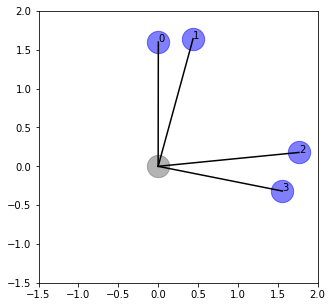

====13th kernel info====
13th-p_support:
torch.Size([4, 2])


13th-x_support:
tensor([[ 2.0302e+00,  1.1581e+00,  1.1573e+00,  1.1566e+00,  1.1565e+00,
          1.0027e+00,  1.2621e+00,  9.9185e-01,  8.8732e-01,  9.5772e-01,
          9.5896e-01,  9.7894e-01,  9.6840e-01,  9.5121e-01,  9.6402e-01,
          9.5615e-01,  9.8767e-01,  9.8505e-01,  9.5645e-01,  9.5377e-01,
          9.7080e-01,  9.5317e-01,  2.9079e-03,  1.4513e-02,  5.3581e-03,
         -4.3653e-03, -1.7312e-03,  1.3422e-03, -1.9775e-03, -5.2115e-04,
          5.1792e-04, -2.7379e-03,  2.9103e-03, -5.1656e-04,  2.6924e-03,
         -4.7618e-04,  2.3861e-03, -1.6482e-04, -2.1990e-03, -1.0452e-03,
          1.7611e-04,  3.5805e-04, -9.2338e-04,  1.0706e-05,  3.1593e-02,
          6.2962e-02,  1.5163e-02,  1.2440e-02,  1.6178e-02,  1.7600e-02,
          1.6692e-02,  1.6598e-02, -1.4051e-03,  1.7770e-03,  1.2341e-02,
          1.1138e-02,  1.7806e-02,  6.4514e-03,  2.0468e-02,  2.0809e-02,
          2.0795e-02,  2.1243e-02,

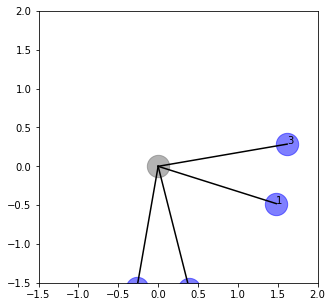

====14th kernel info====
14th-p_support:
torch.Size([4, 2])


14th-x_support:
tensor([[ 5.3374e-01,  5.0723e-01,  4.8514e-01,  4.8460e-01,  4.8456e-01,
          8.7816e-01,  4.6462e-01,  4.0726e-01,  4.0324e-01,  4.0275e-01,
          4.0318e-01,  4.0740e-01,  4.0290e-01,  4.0364e-01,  3.9884e-01,
          3.9889e-01,  4.0687e-01,  4.0785e-01,  3.9905e-01,  3.9972e-01,
          4.0499e-01,  4.0060e-01, -1.8416e-02, -1.2465e-02, -2.3377e-02,
         -8.9327e-03, -1.1047e-02, -1.1281e-02, -1.6797e-02, -9.0275e-03,
         -9.0598e-03, -9.1219e-03, -9.0588e-03, -9.0947e-03, -9.0101e-03,
         -9.0940e-03, -9.0738e-03, -9.1004e-03, -9.1006e-03, -9.0993e-03,
         -9.1011e-03, -9.1170e-03, -9.0952e-03, -9.0580e-03,  5.2088e-01,
          2.8435e-01,  3.7856e-01,  3.6848e-01,  3.7049e-01,  3.7060e-01,
          3.6952e-01,  3.7084e-01,  6.0240e-01,  4.9227e-01,  3.3642e-01,
          3.7062e-01,  3.6916e-01,  3.6758e-01,  4.4644e-01,  4.4969e-01,
          4.4639e-01,  4.5345e-01,

In [30]:
# visualize saved model kernels
model = PredefinedNHopKernelSetConv(D=2, node_attr_dim=93, edge_attr_dim=1, L1=15, L2=15, L3=15, L4=15)
model.load_state_dict(torch.load('../saved_kernellayers/1th_layer.pth'))

print(list(model.state_dict()))
vis_kernel_in_kernelsetconv(model)